# SpaceX Launch Analysis and Prediction

This project analyzes SpaceX launches by integrating data from multiple APIs to understand factors influencing launch success and predict future outcomes.

### Objectives:
1. Integrate data from multiple APIs into a unified dataset.
2. Perform necessary data cleaning at each step of the process.
3. Analyze key trends and build a predictive model.


# Data and More Data

## SpaceX API: Initial Data Collection

We start by fetching core launch data from the SpaceX API.  
The dataset includes:
- Launch dates and times.
- Launch sites.
- Booster types.
- Payloads.
- Mission outcomes.


In [ ]:
import requests
import pandas as pd
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Fetch SpaceX API data
url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(url)
launch_data = response.json()

# Convert to DataFrame
spacex_df = pd.json_normalize(launch_data)
spacex_df.head(1)


,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN


## SpaceX API: Inspecting the Retrieved Data

The raw data contains multiple fields, many of which may not be directly useful.  
Key fields include:
- `flight_number`: The unique identifier for each launch.
- `name`: The name of the mission.
- `date_utc`: The launch date and time in UTC.
- `rocket`: ID referencing the rocket used.
- `launchpad`: ID referencing the launch site.
- `payloads`: List of payload IDs.
- `success`: Mission outcome (True/False).

We inspect the structure and fields to guide further processing.



In [ ]:
# Select relevant columns for analysis
columns_to_keep = [
    'rocket', 'payloads', 'launchpad',
    'cores', 'success', 'flight_number',
    'date_utc'
]
spacex_df = spacex_df[columns_to_keep]

# Expand nested data for cores
spacex_df.loc[:, 'cores'] = spacex_df['cores'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {x})

# Select first payload
spacex_df.loc[:, 'payloads'] = spacex_df['payloads'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {x})

# Rename columns for clarity
spacex_df.rename(columns={'success': 'launch_success', 'landing_success': 'core_landing_success'}, inplace=True)

# Create a date column and select date range
spacex_df['date'] = pd.to_datetime(spacex_df['date_utc']).dt.date
spacex_df = spacex_df[spacex_df['date'] <= dt.date(2020,11,13)]

# Display cleaned data
spacex_df.head(3)


,rocket,payloads,launchpad,cores,launch_success,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",False,1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",False,2,2007-03-21T01:10:00.000Z,2007-03-21
2,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e3,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",False,3,2008-08-03T03:34:00.000Z,2008-08-03


## SpaceX API: Secondary Data Collection
Here we fetch data from the SpaceX API and creates a DataFrame containing detailed information about SpaceX rocket launches.

## Functions:
1. **getBoosterVersion(data)** - Retrieves booster versions based on rocket IDs.
2. **getLaunchSite(data)** - Retrieves launch site details (longitude, latitude, and name).
3. **getPayloadData(data)** - Retrieves payload mass and orbit data.
4. **getCoreData(data)** - Retrieves core-related details such as block number, reuse count, serial number, and landing outcomes.
5. **create_spacex_dataframe(data)** - The main function that fetches all the necessary data and creates a structured DataFrame.

## Usage:
You can use the `create_spacex_dataframe` function with your SpaceX data, which will return a DataFrame with relevant launch information.

In [ ]:
# Helper function to fetch API data
def fetch_api_data(endpoint, id):
    try:
        response = requests.get(f"https://api.spacexdata.com/v4/{endpoint}/{id}")
        response.raise_for_status()  # Check for HTTP errors
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {endpoint}/{id}: {e}")
        return None

# Function to get booster versions
def getBoosterVersion(data):
    booster_versions = []
    for x in data['rocket']:
        if x:
            response = fetch_api_data("rockets", x)
            if response:
                booster_versions.append(response.get('name', None))
    return booster_versions

# Function to get launch site data
def getLaunchSite(data):
    launch_sites = {'Longitude': [], 'Latitude': [], 'LaunchSite': []}
    for x in data['launchpad']:
        if x:
            response = fetch_api_data("launchpads", x)
            if response:
                launch_sites['Longitude'].append(response.get('longitude', None))
                launch_sites['Latitude'].append(response.get('latitude', None))
                launch_sites['LaunchSite'].append(response.get('name', None))
    return launch_sites

# Function to get payload data
def getPayloadData(data):
    payload_data = {'PayloadMass': [], 'Orbit': []}
    for load in data['payloads']:
        if load:
            response = fetch_api_data("payloads", load)
            if response:
                payload_data['PayloadMass'].append(response.get('mass_kg', None))
                payload_data['Orbit'].append(response.get('orbit', None))
    return payload_data

# Function to get core data
def getCoreData(data):
    core_data = {
        'Outcome': [], 'Flights': [], 'GridFins': [], 'Reused': [], 'Legs': [],
        'LandingPad': [], 'Block': [], 'ReusedCount': [], 'Serial': []
    }
    for core in data['cores']:
        if core['core'] is not None:
            response = fetch_api_data("cores", core['core'])
            if response:
                core_data['Block'].append(response.get('block', None))
                core_data['ReusedCount'].append(response.get('reuse_count', None))
                core_data['Serial'].append(response.get('serial', None))
        else:
            core_data['Block'].append(None)
            core_data['ReusedCount'].append(None)
            core_data['Serial'].append(None)

        core_data['Outcome'].append(f"{core.get('landing_success', None)} {core.get('landing_type', None)}")
        core_data['Flights'].append(core.get('flight', None))
        core_data['GridFins'].append(core.get('gridfins', None))
        core_data['Reused'].append(core.get('reused', None))
        core_data['Legs'].append(core.get('legs', None))
        core_data['LandingPad'].append(core.get('landpad', None))

    return core_data

# Main function to create the DataFrame
def create_spacex_dataframe(data):
    booster_versions = getBoosterVersion(data)
    launch_sites = getLaunchSite(data)
    payload_data = getPayloadData(data)
    core_data = getCoreData(data)

    # Create DataFrame
    final_df = pd.DataFrame({
        'Date': data['date'],
        'FlightNumber': data['flight_number'],
        'BoosterVersion': booster_versions,
        'PayloadMass': payload_data['PayloadMass'],
        'Orbit': payload_data['Orbit'],
        'LaunchSite': launch_sites['LaunchSite'],
        'Longitude': launch_sites['Longitude'],
        'Latitude': launch_sites['Latitude'],
        'Outcome': core_data['Outcome'],
        'Flights': core_data['Flights'],
        'GridFins': core_data['GridFins'],
        'Reused': core_data['Reused'],
        'Legs': core_data['Legs'],
        'LandingPad': core_data['LandingPad'],
        'Block': core_data['Block'],
        'ReusedCount': core_data['ReusedCount'],
        'Serial': core_data['Serial']
    })

    return final_df

In [ ]:
spacex_new_df = create_spacex_dataframe(spacex_df)
spacex_new_df.head(3)

,Date,FlightNumber,BoosterVersion,PayloadMass,Orbit,LaunchSite,Longitude,Latitude,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,2006-03-24,1,Falcon 1,20.0,LEO,Kwajalein Atoll,167.743129,9.047721,None None,1,False,False,False,None,NaN,0,Merlin1A
1,2007-03-21,2,Falcon 1,NaN,LEO,Kwajalein Atoll,167.743129,9.047721,None None,1,False,False,False,None,NaN,0,Merlin2A
2,2008-08-03,3,Falcon 1,NaN,LEO,Kwajalein Atoll,167.743129,9.047721,None None,1,False,False,False,None,NaN,0,Merlin1C


## SpaceX API: Data Preprocessing and Outcome Classification

This section of the notebook performs data preprocessing on the SpaceX dataset, specifically focusing on Falcon 9 launches. It handles missing values, assigns new values to columns, and classifies outcomes based on specific conditions.


In [ ]:
# Count the number of occurrences of each unique Booster Version
spacex_new_df.BoosterVersion.value_counts()

# Check for missing values in the dataset
spacex_new_df.isnull().sum()

# Filter out Falcon 1 launches to focus on Falcon 9 data
data_falcon9 = spacex_new_df[spacex_new_df['BoosterVersion'] != 'Falcon 1']

# Fill missing PayloadMass values with the mean value of the column
data_falcon9.loc[:,'PayloadMass'] = data_falcon9['PayloadMass'].fillna(data_falcon9['PayloadMass'].mean())

# Assign sequential flight numbers starting from 1
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))

# List of "bad" outcomes to classify unsuccessful launches
bad_outcomes = ['None None', 'False ASDS', 'False Ocean', 'None ASDS','False RTLS']

# Create a new 'Class' column where 1 represents a successful launch and 0 represents a failed launch
data_falcon9.loc[:, 'Class'] = data_falcon9['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)

<ipython-input-5-4e91fcb60d33>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:, 'Class'] = data_falcon9['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)


In [ ]:
data_falcon9.head(10)

,Date,FlightNumber,BoosterVersion,PayloadMass,Orbit,LaunchSite,Longitude,Latitude,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
5,2010-06-04,1,Falcon 9,5882.69,LEO,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B0003,0
6,2010-12-08,2,Falcon 9,5882.69,LEO,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B0004,0
7,2012-05-22,3,Falcon 9,525.00,LEO,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B0005,0
8,2012-10-08,4,Falcon 9,400.00,ISS,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B0006,0
9,2013-03-01,5,Falcon 9,677.00,ISS,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B0007,0
10,2013-09-29,6,Falcon 9,500.00,PO,VAFB SLC 4E,-120.610829,34.632093,False Ocean,1,False,False,False,None,1.0,0,B1003,0
11,2013-12-03,7,Falcon 9,3170.00,GTO,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B1004,0
12,2014-01-06,8,Falcon 9,3325.00,GTO,CCSFS SLC 40,-80.577366,28.561857,None None,1,False,False,False,None,1.0,0,B1005,0
13,2014-04-18,9,Falcon 9,2296.00,ISS,CCSFS SLC 40,-80.577366,28.561857,True Ocean,1,False,False,True,None,1.0,0,B1006,1
14,2014-07-14,10,Falcon 9,1316.00,LEO,CCSFS SLC 40,-80.577366,28.561857,True Ocean,1,False,False,True,None,1.0,0,B1007,1


## WebScrapping: Data Collection - Wikipedia

This section extracts launch data for Falcon 9 and Falcon Heavy missions from a Wikipedia page. The data is parsed from HTML tables and organized into a Pandas DataFrame for further analysis.


In [ ]:
from bs4 import BeautifulSoup as bs
import unicodedata

In [ ]:
# URL for the Wikipedia page listing SpaceX launches
url = 'https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922'
response = requests.get(url)

In [ ]:
# Parsing the HTML content with BeautifulSoup
soup = bs(response.content, 'html.parser')
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [ ]:
# Extracting all tables with class 'wikitable plainrowheaders collapsible'
html_tables = soup.find_all('table', class_="wikitable plainrowheaders collapsible")

In [ ]:
# Function to extract and clean column names from table headers
def extract_column_from_header(row):
    """
    Extracts column names from HTML table headers by removing unwanted elements (e.g., <br>, <a>, <sup>).
    Input: row (BeautifulSoup element)
    Output: Cleaned column name string
    """
    # Remove unwanted HTML tags
    for tag in ['br', 'a', 'sup']:
        for match in row.find_all(tag):
            match.extract()

    column_name = ' '.join(row.stripped_strings)

    # Filter out numeric values and empty strings
    if column_name.strip() and not column_name.strip().isdigit():
        return column_name.strip()
    return None

# Function to extract date and time from table cells
def date_time(table_cells):
    """
    Extracts the date and time from a table cell.
    Input: table_cells (BeautifulSoup element)
    Output: List containing the date and time as strings
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

# Function to extract the booster version from table cells
def booster_version(table_cells):
    """
    Extracts the booster version from the table cell.
    Input: table_cells (BeautifulSoup element)
    Output: Booster version string
    """
    return ''.join([booster_version for i, booster_version in enumerate(table_cells.strings) if i % 2 == 0]).strip()

# Function to extract payload mass from table cells
def get_mass(table_cells):
    """
    Extracts and returns the payload mass from the table cell.
    Input: table_cells (BeautifulSoup element)
    Output: Payload mass string (with 'kg' suffix if available)
    """
    mass = unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass = mass.split("kg")[0] + " kg" if "kg" in mass else "0 kg"
    else:
        mass = "0 kg"
    return mass

# Function to extract landing status from table cells
def landing_status(table_cells):
    """
    Extracts the landing status from the table cell.
    Input: table_cells (BeautifulSoup element)
    Output: Landing status string
    """
    return next(table_cells.strings).strip()

In [ ]:
# Extract column headers
column_names = [extract_column_from_header(row) for row in html_tables[0].find_all('th')]
column_names = [name for name in column_names if name]

In [ ]:
# Initialize dictionary for storing extracted data
launch_dict = dict.fromkeys(column_names)
del launch_dict['Date and time ( )']  # Removing unnecessary column

In [ ]:
# Add specific columns to the dictionary
launch_dict.update({
    'Flight No.': [],
    'Launch site': [],
    'Payload': [],
    'Payload mass': [],
    'Orbit': [],
    'Customer': [],
    'Launch outcome': [],
    'Version Booster': [],
    'Booster landing': [],
    'Date': [],
    'Time': []
})

In [ ]:
# Extract data for each row in the tables
extracted_row = 0
for table_number, table in enumerate(html_tables):
    for rows in table.find_all("tr"):
        if rows.th and rows.th.string:
            flight_number = rows.th.string.strip()
            flag = flight_number.isdigit()

            # If flight number is valid, process the row
            if flag:
                extracted_row += 1
                row = rows.find_all('td')

                # Populate the dictionary with extracted data
                launch_dict['Flight No.'].append(flight_number)
                datatimelist = date_time(row[0])

                # Extract date and time
                launch_dict['Date'].append(datatimelist[0].strip(','))
                launch_dict['Time'].append(datatimelist[1])

                # Extract booster version
                bv = booster_version(row[1]) or row[1].a.string
                launch_dict['Version Booster'].append(bv)

                # Extract launch site, payload, and other details
                launch_dict['Launch site'].append(row[2].a.string)
                launch_dict['Payload'].append(row[3].a.string)
                launch_dict['Payload mass'].append(get_mass(row[4]))
                launch_dict['Orbit'].append(row[5].a.string)
                launch_dict['Customer'].append(row[6].a.string if row[6].a else 'None')
                launch_dict['Launch outcome'].append(next(row[7].strings).strip())
                launch_dict['Booster landing'].append(landing_status(row[8]))

In [ ]:
# Create a pandas DataFrame from the dictionary
wiki_df = pd.DataFrame({key: pd.Series(value) for key, value in launch_dict.items()})

In [ ]:
wiki_df.head(2)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0 kg,LEO,SpaceX,Success,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0 kg,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43


# Exploratory Data Analysis (EDA)

In this stage, we explore the dataset using SQL queries and various visualizations to understand the underlying patterns, detect potential issues such as missing values, and gain insights that can guide model development. We will use `matplotlib`, `seaborn`, and `plotly` for visualization, as well as SQL for data exploration.

## SQL

In [ ]:
!pip install sqlalchemy==1.3.9
!pip install ipython-sql
# !pip install ipython-sql prettytable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.9-cp311-cp311-linux_x86_64.whl size=1193599 sha256=eb051ed755774d6c99ba2b757968daec34e57b8ef639ced358420c1b69087818
  Stored in directory: /root/.cache/pip/wheels/3a/7c/1e/12404784a68083eb969f877a1808a1847bab897684b56ddc55
Successfully built sqlalchemy
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.37
    Uninstalling SQLAlchemy-2.0.37:
      Successfully uninstalled SQLAlchemy-2.0.37
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.33.0 requires sqlalchemy<3.0dev,>=1.4, but you have sqlalchemy 1.3.9 which is incompatible.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.3.9 which is incompatible.
langchain 0.3.15 require

In [ ]:
import sqlite3
import prettytable

prettytable.DEFAULT = 'DEFAULT'

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('my_data1.db')
cur = conn.cursor()

In [ ]:
# Use the %sql magic to interact with SQLite database in Colab
%load_ext sql
%sql sqlite:///my_data1.db

In [ ]:
# Load data_falcon9 into the database
data_falcon9.to_sql("SPACEXTBL", conn, if_exists='replace', index=False, method="multi")

101

Inspect the schema of the `SPACEXTBL` table to understand the column names and their data types.

In [ ]:
%%sql
  SELECT *
  FROM PRAGMA_TABLE_INFO('SPACEXTBL');

 * sqlite:///my_data1.db
Done.


cid,name,type,notnull,dflt_value,pk
0,Date,DATE,0,None,0
1,FlightNumber,INTEGER,0,None,0
2,BoosterVersion,TEXT,0,None,0
3,PayloadMass,REAL,0,None,0
4,Orbit,TEXT,0,None,0
5,LaunchSite,TEXT,0,None,0
6,Longitude,REAL,0,None,0
7,Latitude,REAL,0,None,0
8,Outcome,TEXT,0,None,0
9,Flights,INTEGER,0,None,0


Retrieve all unique `LaunchSite` from the SPACEXTBL table.

In [ ]:
%%sql
  SELECT DISTINCT(LaunchSite)
  FROM SPACEXTBL;

 * sqlite:///my_data1.db
Done.


LaunchSite
CCSFS SLC 40
VAFB SLC 4E
KSC LC 39A


Retrieve up to 5 rows where the `LaunchSite` contains "CCS"

In [ ]:
%%sql
  SELECT *
  FROM SPACEXTBL
  WHERE LaunchSite LIKE '%CCS%'
  LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,FlightNumber,BoosterVersion,PayloadMass,Orbit,LaunchSite,Longitude,Latitude,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
2010-06-04,1,Falcon 9,5882.6900000000005,LEO,CCSFS SLC 40,-80.577366,28.5618571,None None,1,0,0,0,None,1.0,0,B0003,0
2010-12-08,2,Falcon 9,5882.6900000000005,LEO,CCSFS SLC 40,-80.577366,28.5618571,None None,1,0,0,0,None,1.0,0,B0004,0
2012-05-22,3,Falcon 9,525.0,LEO,CCSFS SLC 40,-80.577366,28.5618571,None None,1,0,0,0,None,1.0,0,B0005,0
2012-10-08,4,Falcon 9,400.0,ISS,CCSFS SLC 40,-80.577366,28.5618571,None None,1,0,0,0,None,1.0,0,B0006,0
2013-03-01,5,Falcon 9,677.0,ISS,CCSFS SLC 40,-80.577366,28.5618571,None None,1,0,0,0,None,1.0,0,B0007,0


Calculate the average `PayloadMass` for missions using the Falcon 9 booster version.

In [ ]:
%%sql
  SELECT AVG(PayloadMass) AS 'Average Payload Mass'
  FROM SPACEXTBL
  WHERE BoosterVersion = 'Falcon 9';

 * sqlite:///my_data1.db
Done.


Average Payload Mass
5981.649897959183


Identify the first successful launch date.

In [ ]:
query = """
SELECT Date AS 'First Success Date'
  FROM SPACEXTBL
  WHERE Class = 1
  ORDER BY Date ASC
  LIMIT 1;"""

print(pd.read_sql(query, conn))

  First Success Date
0         2014-04-18


Find the `BoosterVersion` for payloads between 4000 and 6000 kg with successful outcomes.


In [ ]:
query = """
SELECT BoosterVersion
FROM SPACEXTBL
WHERE PayloadMass = (
  SELECT PayloadMass
  FROM SPACEXTBL
  WHERE PayloadMass > 4000 AND PayloadMass < 6000 AND Class = 1
);"""

print(pd.read_sql(query, conn))

  BoosterVersion
0       Falcon 9


Count the number of occurrences for each `Outcome`

In [ ]:
query = """
  SELECT Outcome, COUNT(*)
  FROM SPACEXTBL
  GROUP BY Outcome;"""

print(pd.read_sql(query, conn))

       Outcome  COUNT(*)
0   False ASDS         9
1  False Ocean         2
2   False RTLS         1
3    None ASDS         2
4    None None        24
5    True ASDS        44
6   True Ocean         5
7    True RTLS        14


Calculate the percentage of successful and failed launches.

In [ ]:
query = """
SELECT CASE Class
    WHEN 0 THEN 'Failure'
    WHEN 1 THEN 'Success'
  END AS Outcome,
  ROUND(CAST(COUNT(*) AS REAL) * 100 / (SELECT COUNT(*) FROM SPACEXTBL), 2) AS Percentage
FROM SPACEXTBL
GROUP BY Class;
"""
print(pd.read_sql(query, conn))

   Outcome  Percentage
0  Failure       37.62
1  Success       62.38


Identify the `BoosterVersion` that carried the maximum payload.

In [ ]:
%%sql
SELECT DISTINCT(BoosterVersion) AS 'Maximum Load Booster'
FROM SPACEXTBL
WHERE PayloadMass = (
  SELECT MAX(PayloadMass)
  FROM SPACEXTBL
);

 * sqlite:///my_data1.db
Done.


Maximum Load Booster
Falcon 9


Retrieve launch details from 2015 with the `Outcome`"False ASDS".

In [ ]:
query = """
SELECT CASE CAST(SUBSTR(Date, 6, 7) AS INTEGER)
    WHEN 01 THEN 'Jan'
    WHEN 02 THEN 'Feb'
    WHEN 03 THEN 'Mar'
    WHEN 04 THEN 'Apr'
    WHEN 05 THEN 'May'
    WHEN 06 THEN 'Jun'
    WHEN 07 THEN 'Jul'
    WHEN 08 THEN 'Aug'
    WHEN 09 THEN 'Sep'
    WHEN 10 THEN 'Oct'
    WHEN 11 THEN 'Nov'
    WHEN 12 THEN 'Dec'
    ELSE 'Other'
  END AS 'Month Name',
  Date, Outcome, BoosterVersion, LaunchSite
FROM SPACEXTBL
WHERE Outcome = 'False ASDS'
  AND CAST(SUBSTR(Date, 0, 5) AS INTEGER) = 2015
ORDER BY Date ASC;
"""
print(pd.read_sql(query, conn))

  Month Name        Date     Outcome BoosterVersion    LaunchSite
0        Jan  2015-01-10  False ASDS       Falcon 9  CCSFS SLC 40
1        Apr  2015-04-14  False ASDS       Falcon 9  CCSFS SLC 40


Count occurrences of each outcome between two dates

In [ ]:
%%sql
SELECT Outcome, COUNT(Outcome), Date
FROM SPACEXTBL
WHERE Date BETWEEN '2010-06-04' AND '2017-03-20'
GROUP BY Outcome
ORDER BY COUNT(Outcome) DESC;

 * sqlite:///my_data1.db
Done.


Outcome,COUNT(Outcome),Date
None None,12,2010-06-04
True ASDS,5,2016-04-08
False ASDS,5,2015-01-10
True RTLS,3,2015-12-22
True Ocean,3,2014-04-18
None ASDS,2,2015-06-28
False Ocean,2,2013-09-29


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

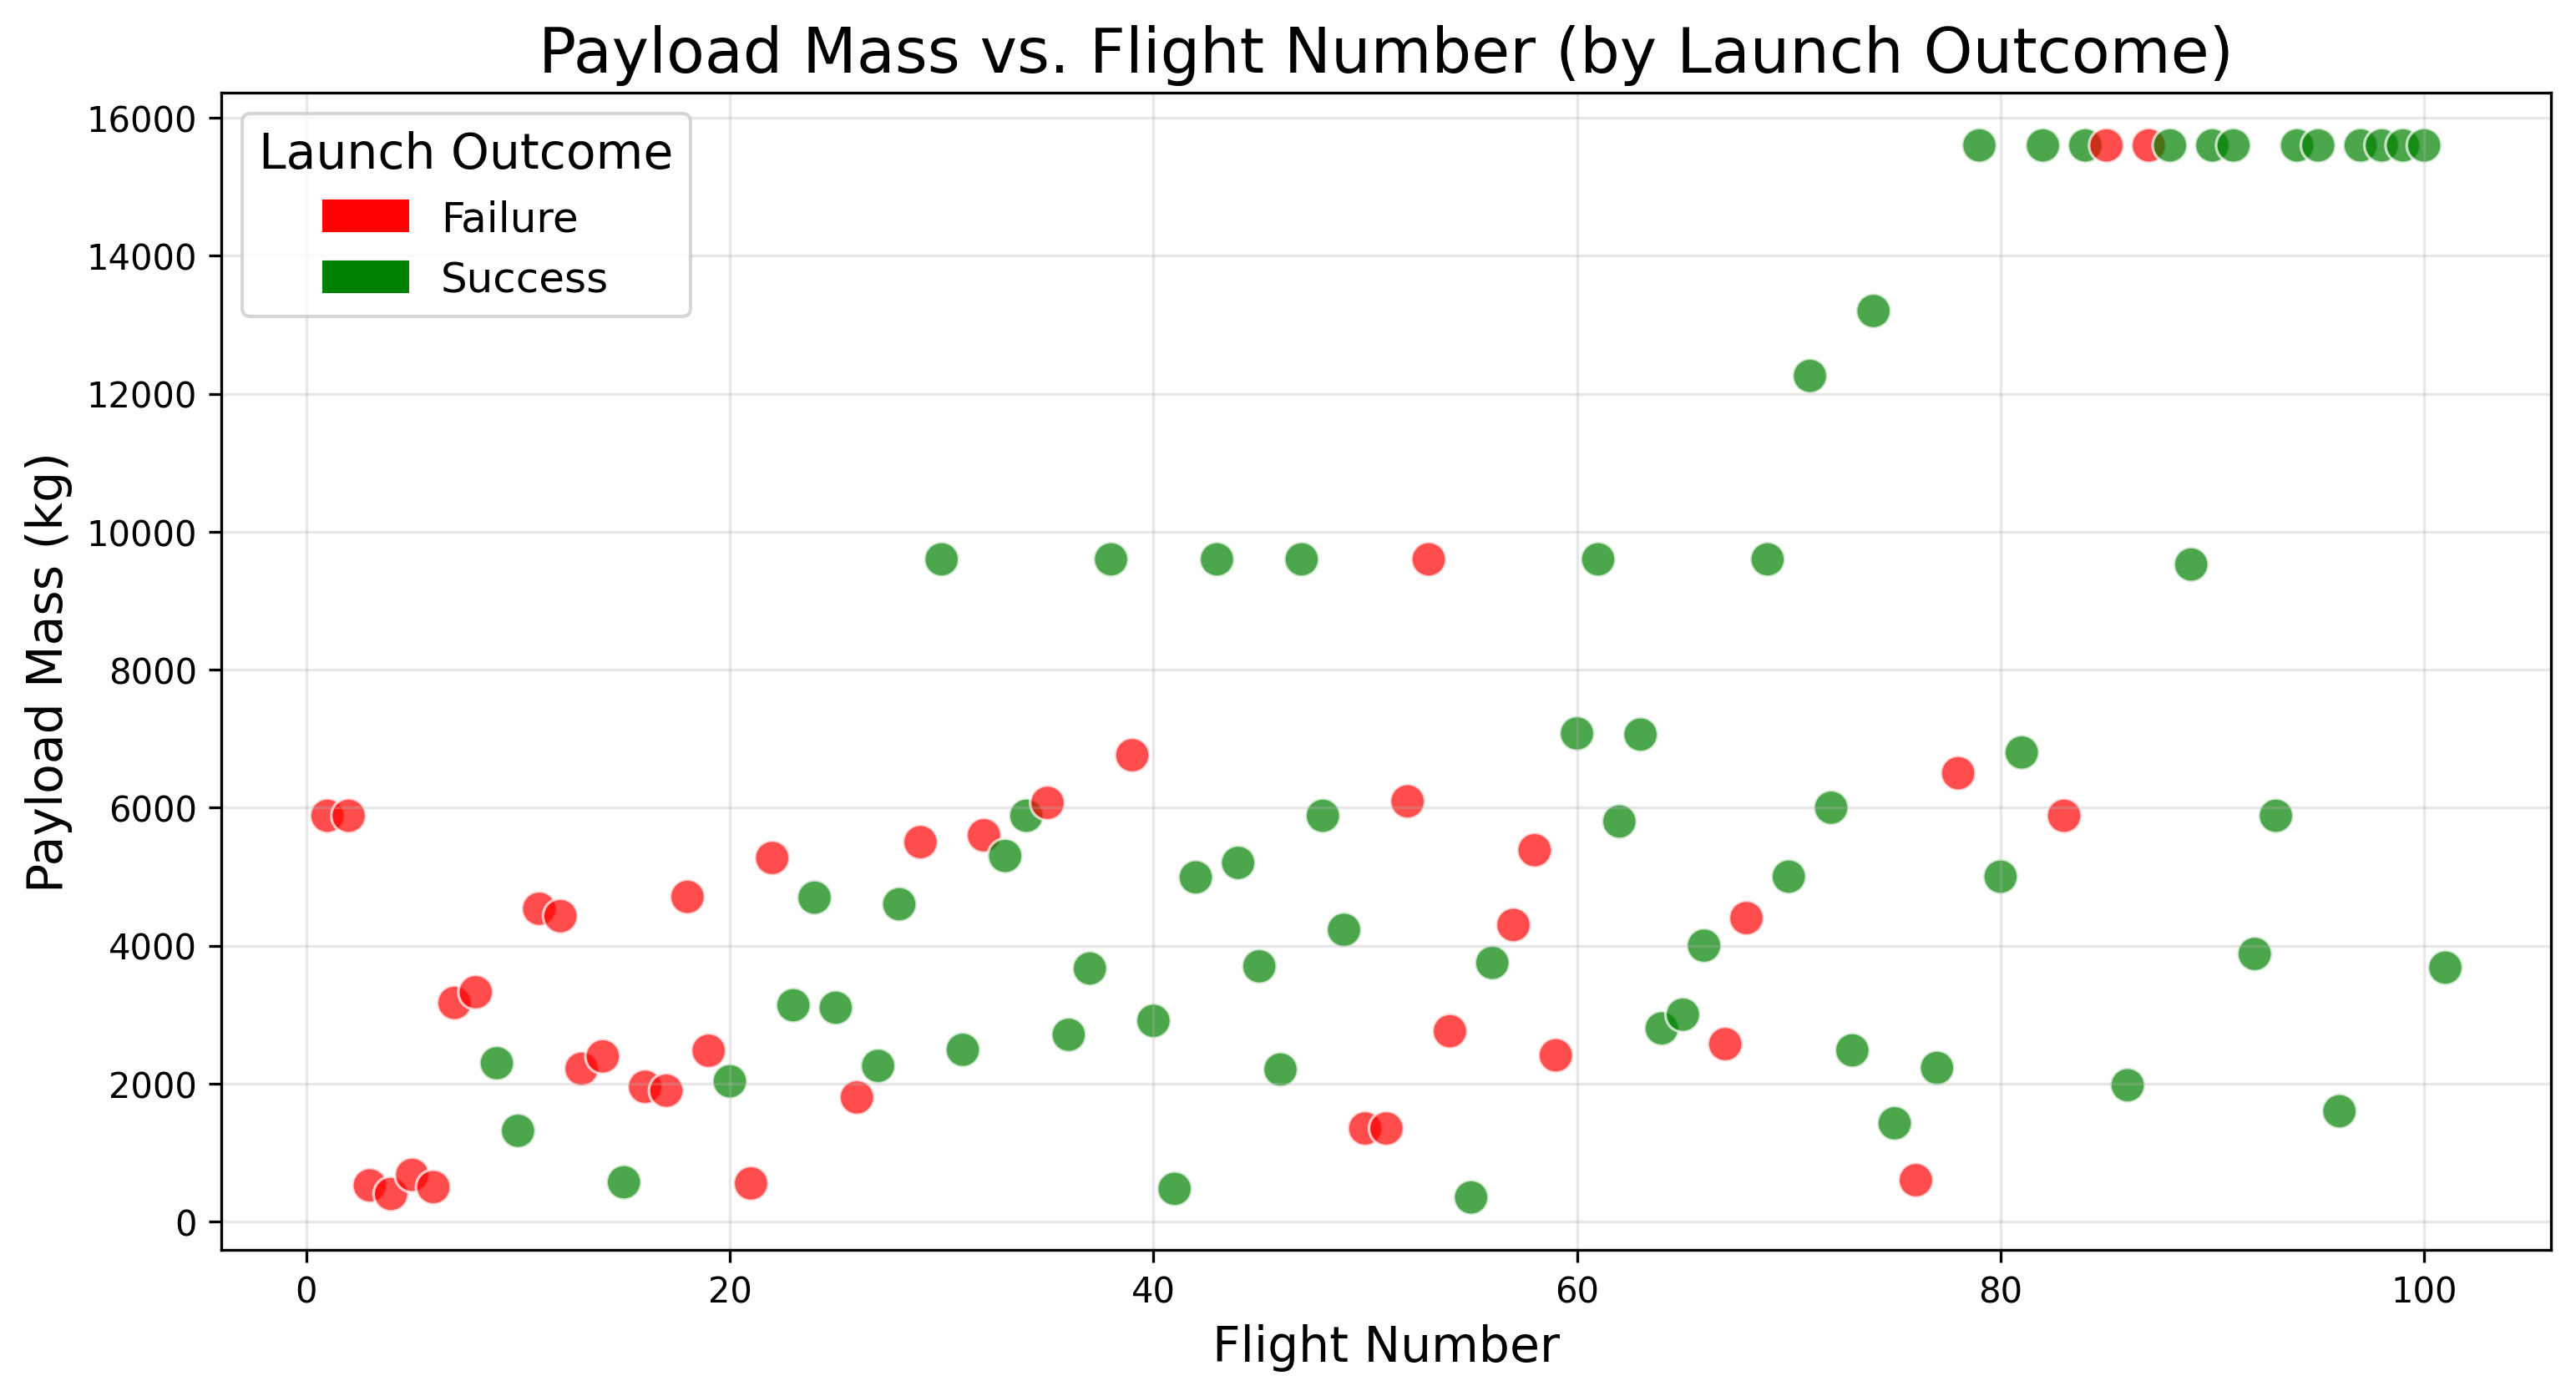

In [ ]:
#scatterplot for Payload Mass vs. Flight Number
plt.figure(figsize=(12, 6), dpi=300)
sns.scatterplot(
    x="FlightNumber",
    y="PayloadMass",
    hue="Class",
    data=data_falcon9,
    palette={0: 'red', 1: 'green'},
    alpha=0.7,
    s=100
)

# Adding labels and a title
plt.title("Payload Mass vs. Flight Number (by Launch Outcome)", fontsize=18)
plt.xlabel("Flight Number", fontsize=14)
plt.ylabel("Payload Mass (kg)", fontsize=14)

legend_handles = [
    mpatches.Patch(color='red', label='Failure'),    # Red for Failure
    mpatches.Patch(color='green', label='Success')  # Green for Success
]
plt.legend(handles=legend_handles, title="Launch Outcome", fontsize=12, title_fontsize=14)
plt.grid(alpha=0.3)

# Display the plot
plt.show()

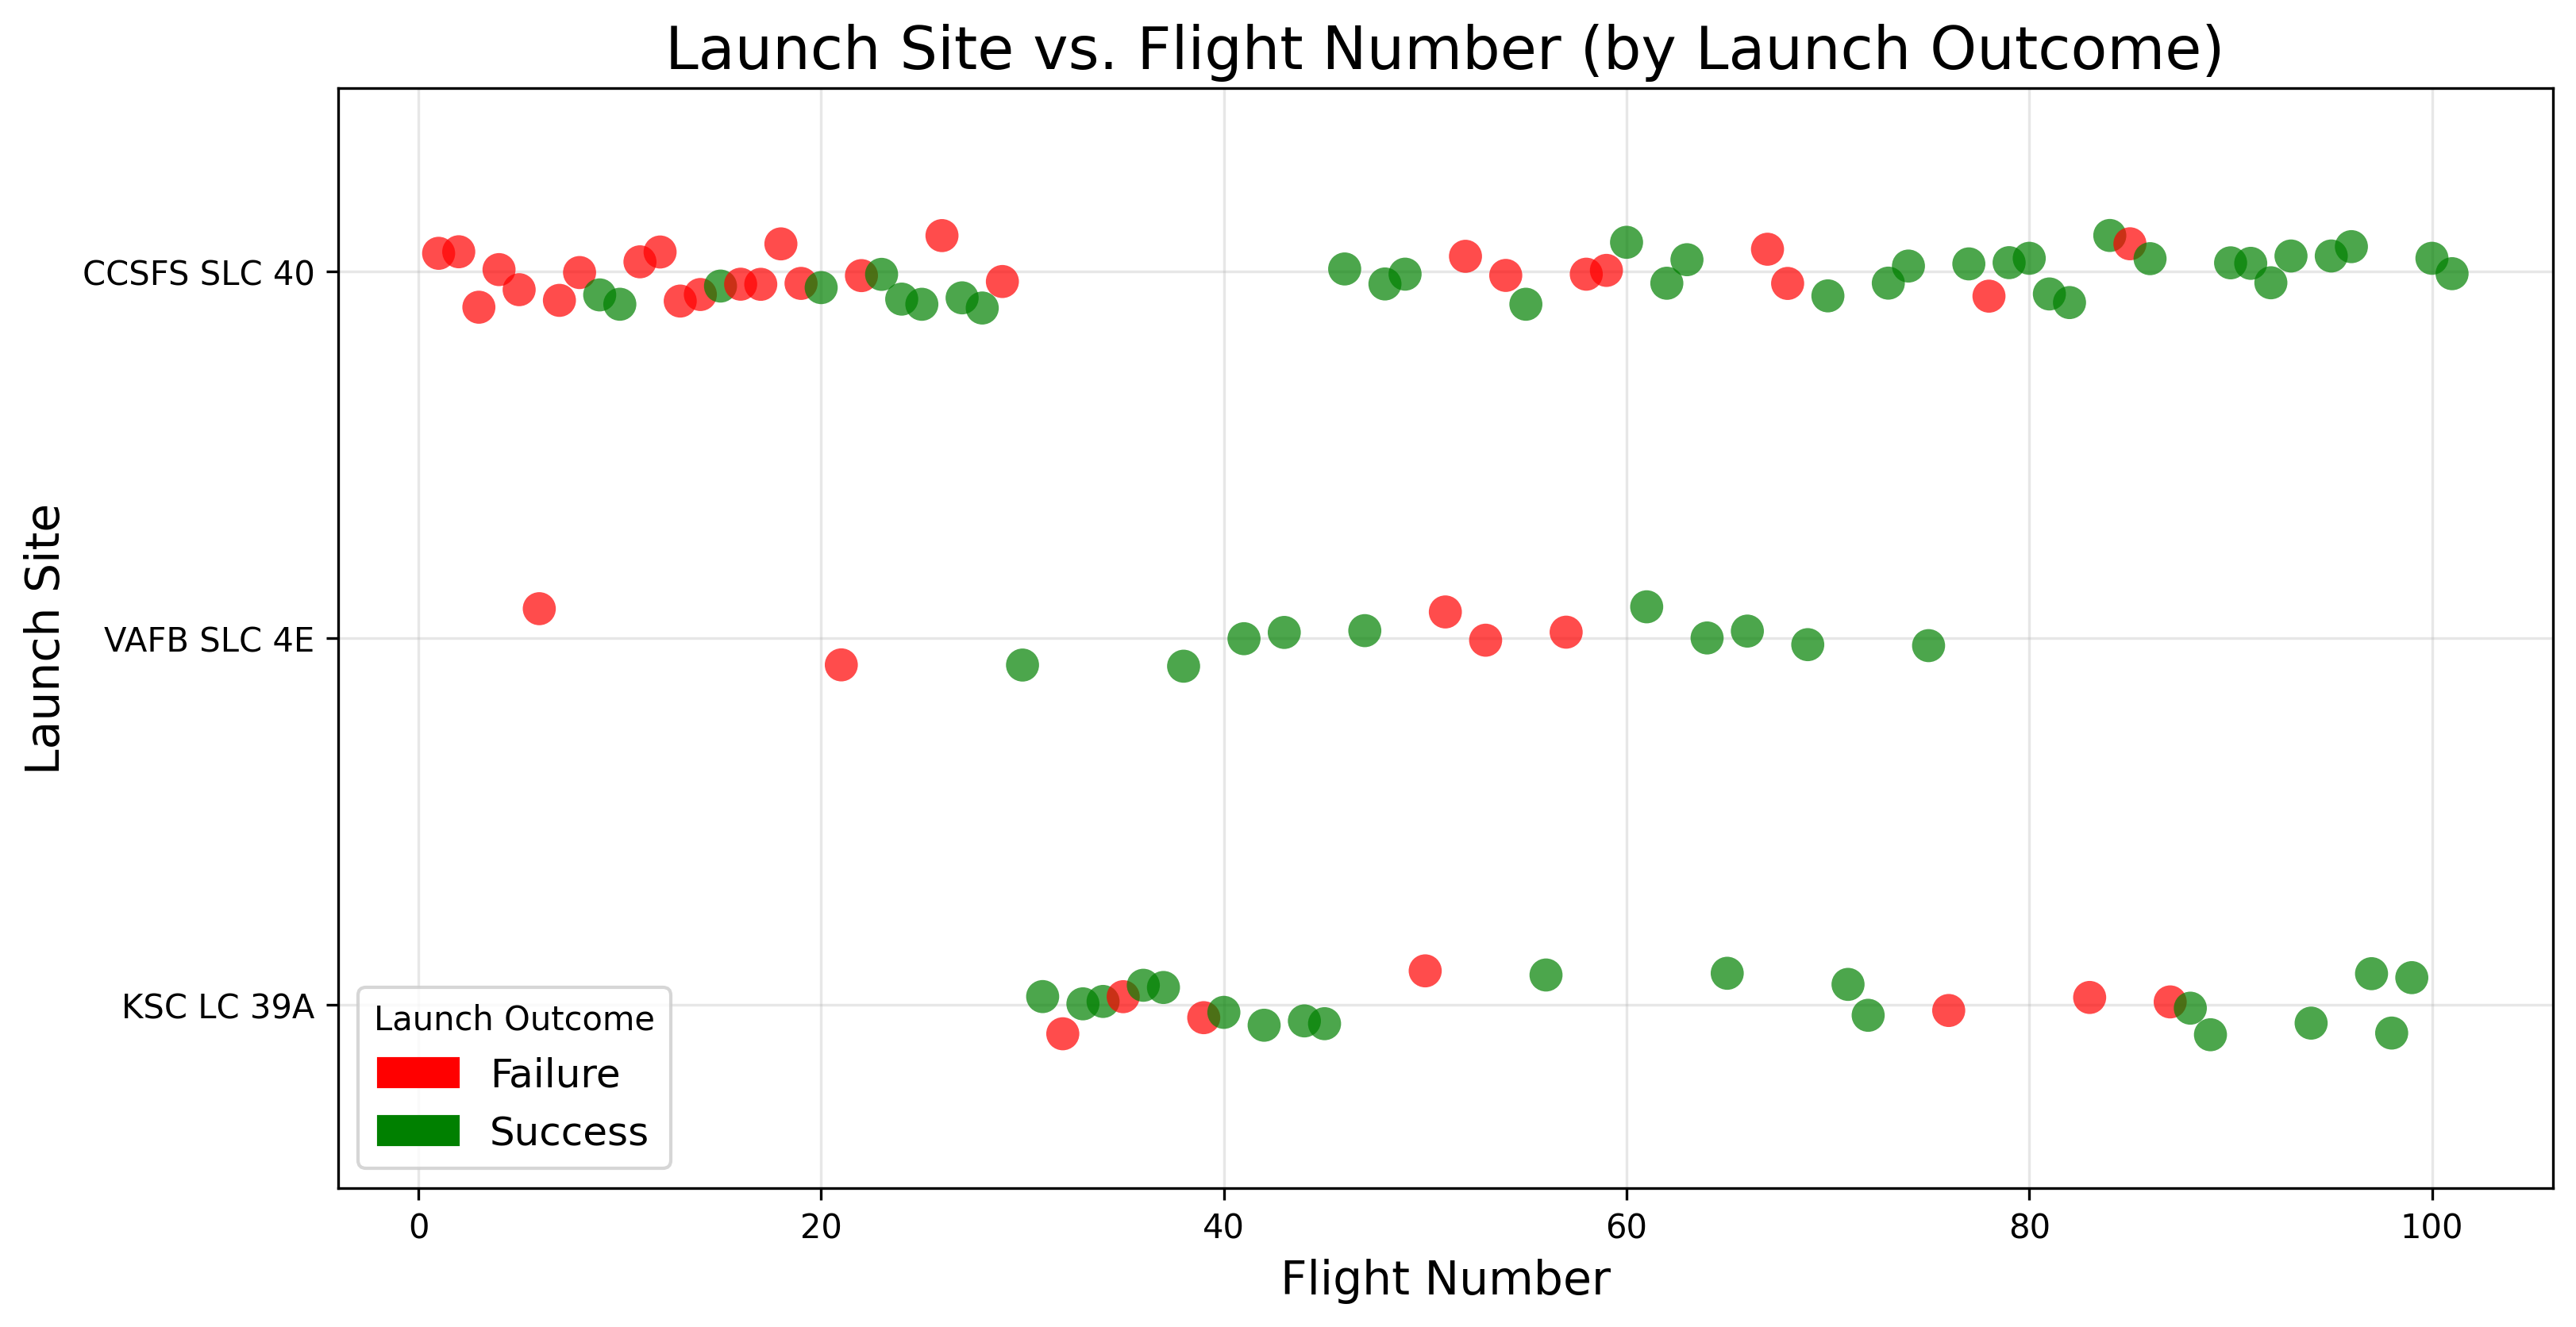

In [ ]:
# Stripplot for Launch Site vs. Flight Number
plt.figure(figsize=(12, 6), dpi=300)
sns.stripplot(
    y="LaunchSite",
    x="FlightNumber",
    hue="Class",
    data=data_falcon9,
    palette={0: 'red', 1: 'green'},
    size=10,
    alpha=0.7,
    jitter=True
)

plt.title("Launch Site vs. Flight Number (by Launch Outcome)", fontsize=18)
plt.xlabel("Flight Number", fontsize=14)
plt.ylabel("Launch Site", fontsize=14)
legend_handles = [
    mpatches.Patch(color='red', label='Failure'),    # Red for Failure
    mpatches.Patch(color='green', label='Success')  # Green for Success
]
plt.legend(title="Launch Outcome", handles = legend_handles, fontsize=12)
plt.grid(alpha=0.3)
plt.show()

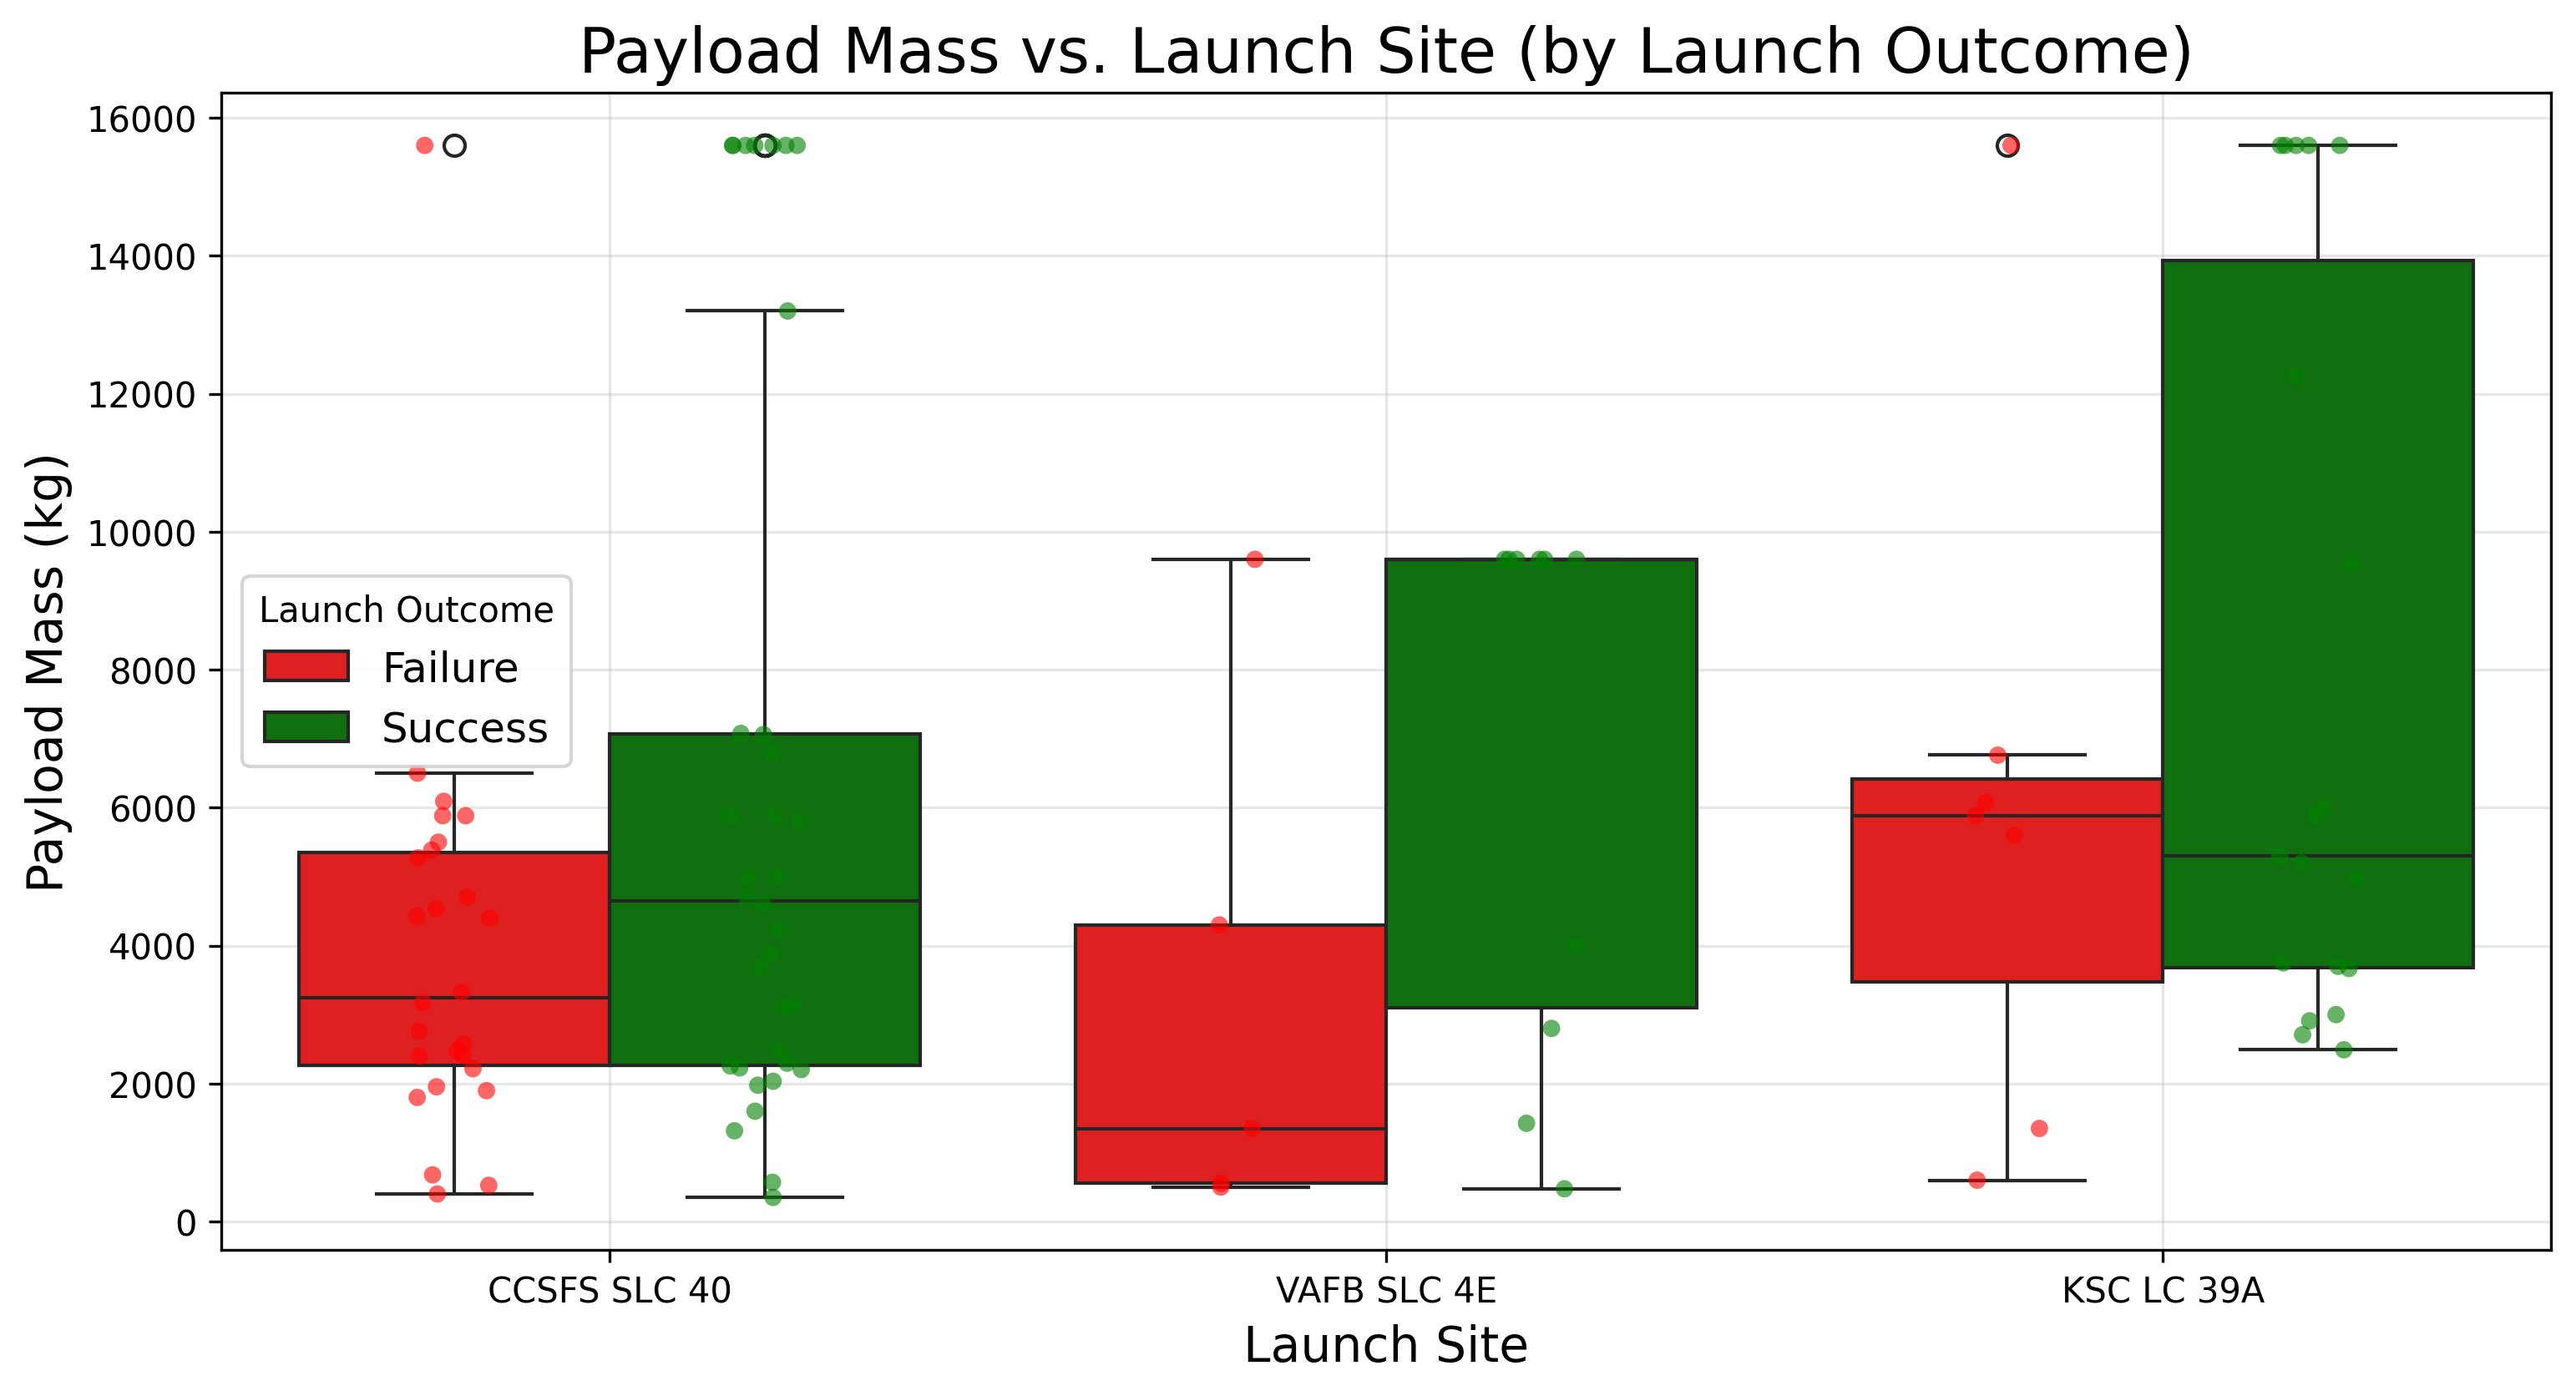

In [ ]:
# Boxplot for Payload Mass vs. Launch Site
plt.figure(figsize=(12, 6), dpi=300)
sns.boxplot(
    x="LaunchSite",
    y="PayloadMass",
    hue="Class",
    data=data_falcon9,
    palette={0: 'red', 1: 'green'}
)
sns.stripplot(
    x="LaunchSite",
    y="PayloadMass",
    hue="Class",
    data=data_falcon9,
    dodge=True,
    palette={0: 'red', 1: 'green'},
    alpha=0.6,
    jitter=True
)

# Adding labels, title, and legend
plt.title("Payload Mass vs. Launch Site (by Launch Outcome)", fontsize=18)
plt.xlabel("Launch Site", fontsize=14)
plt.ylabel("Payload Mass (kg)", fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:2],  # Show only one legend for hue
    ["Failure", "Success"],
    title="Launch Outcome",
    fontsize=12
)
plt.grid(alpha=0.3)

# Display the plot
plt.show()

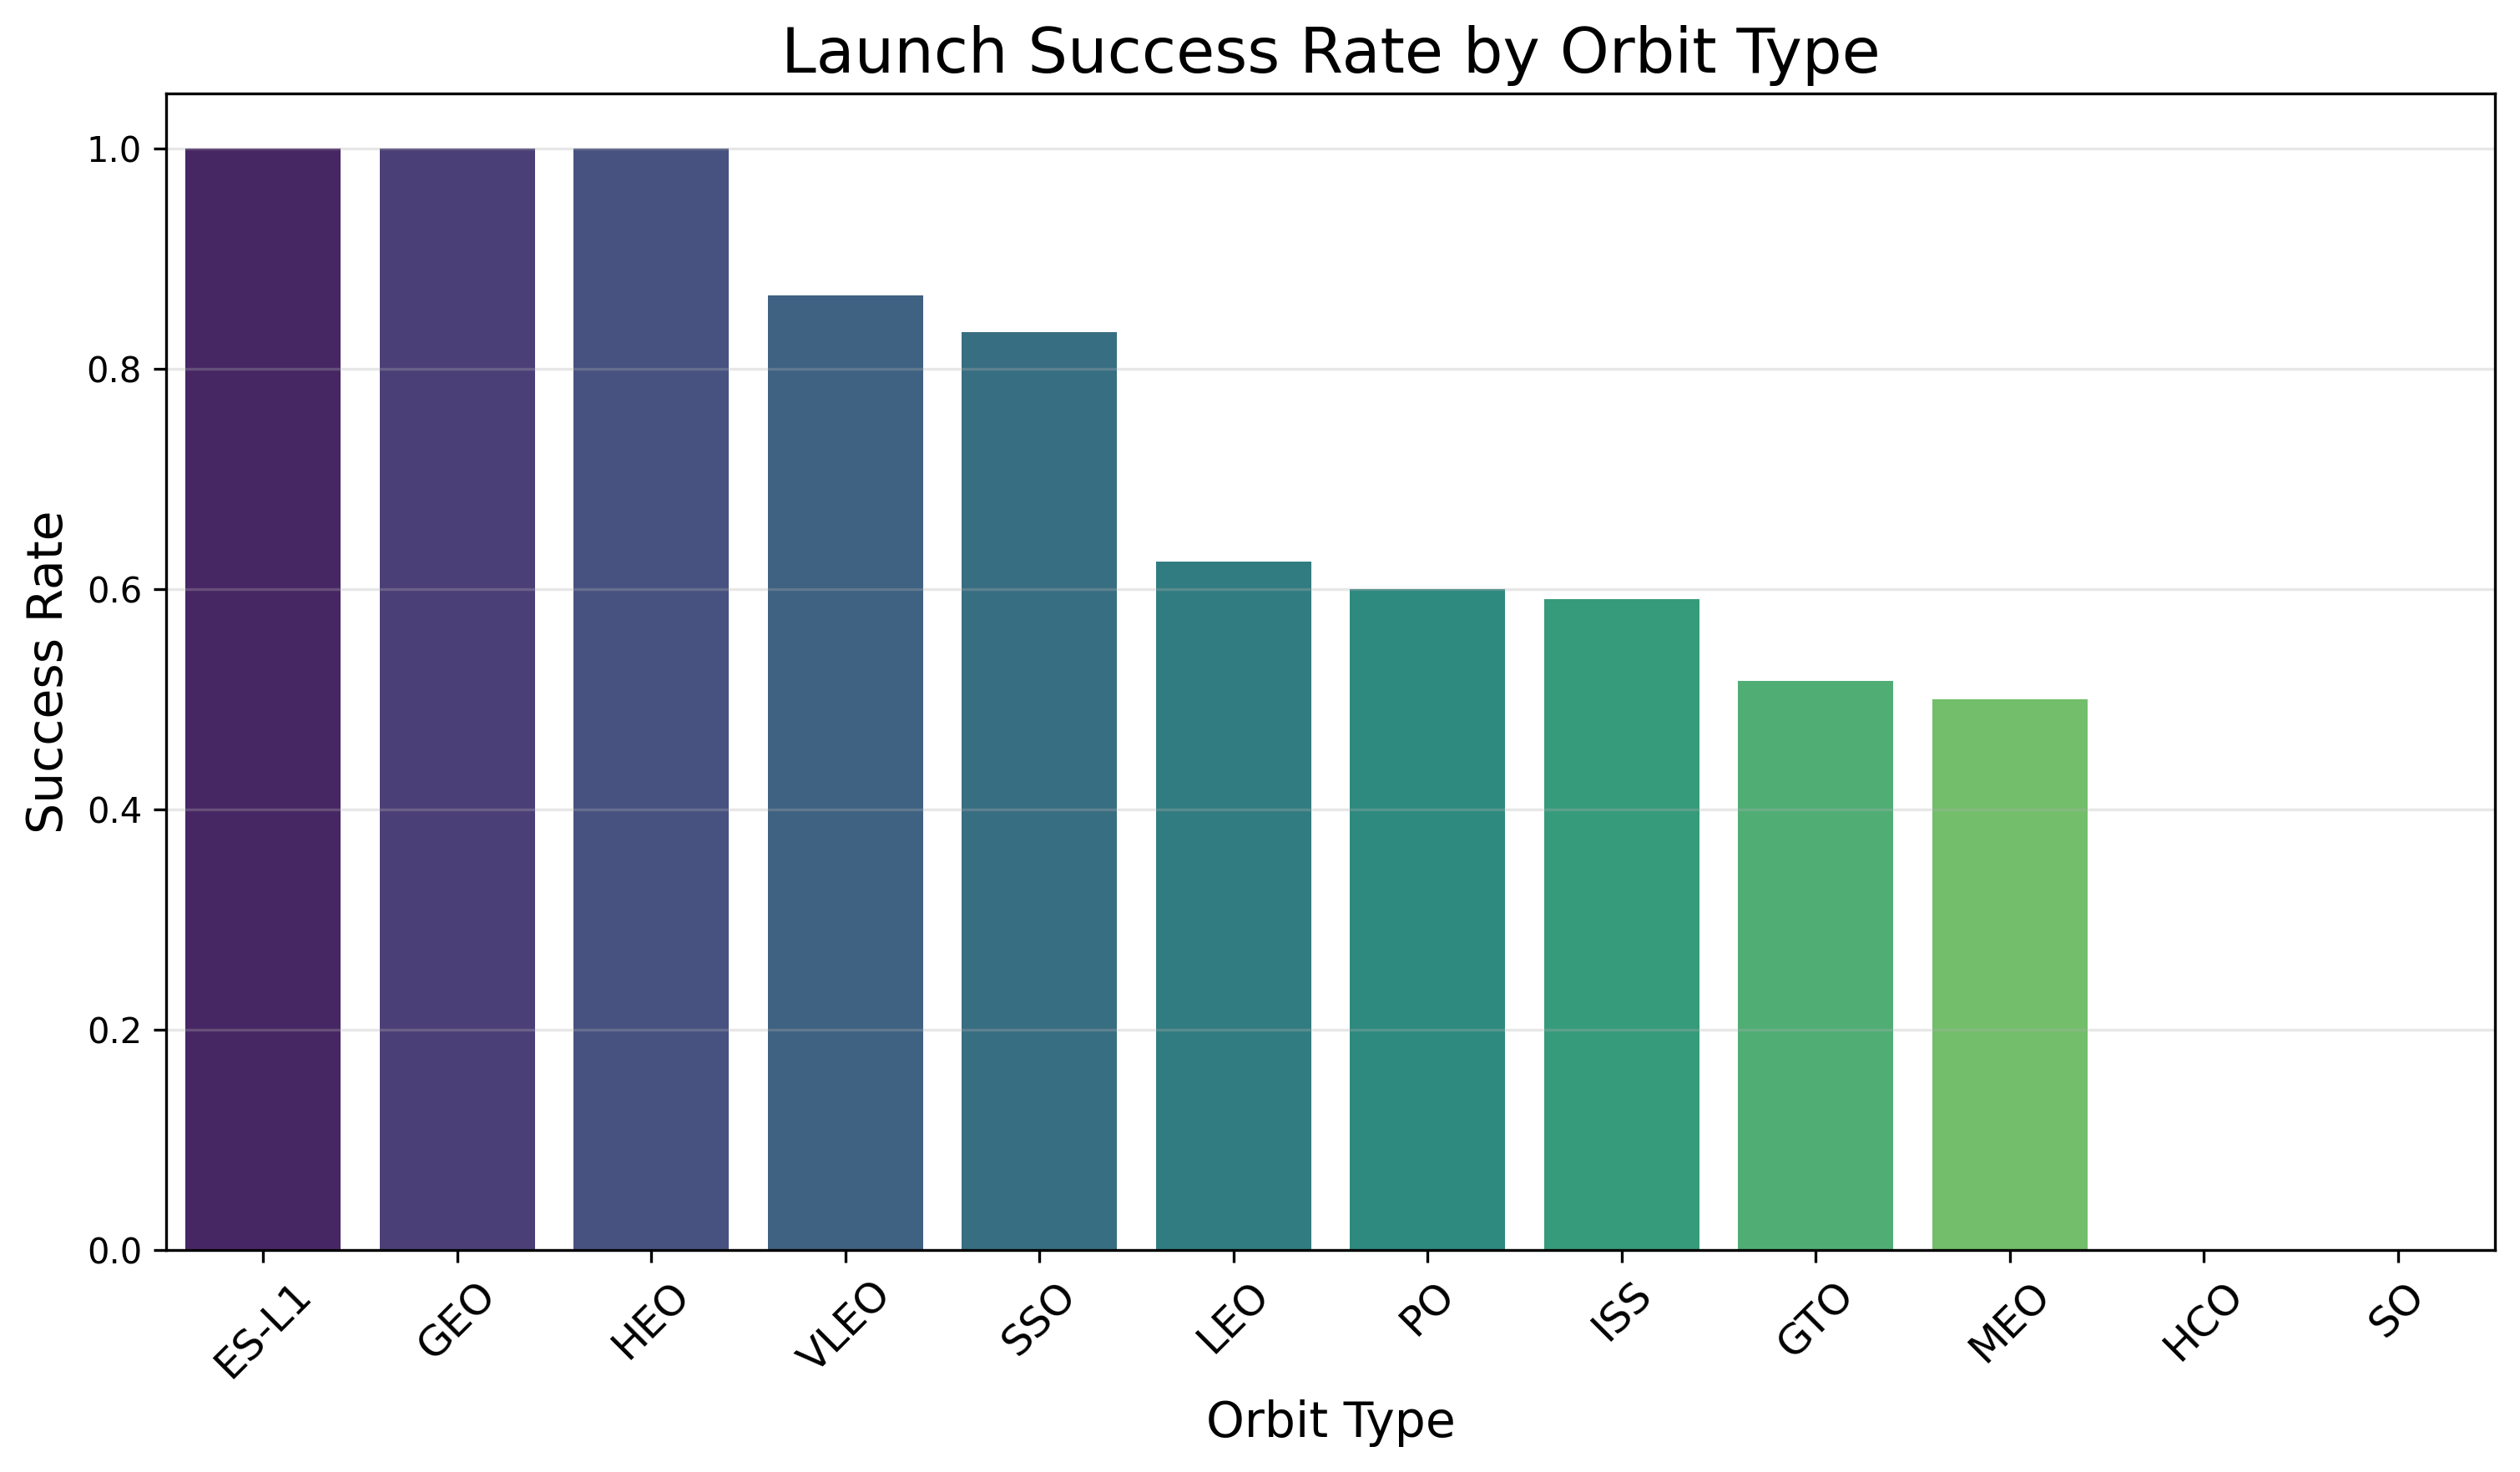

In [ ]:
# Calculate success rate by orbit and sort by success rate
orbit_success_df = data_falcon9.groupby(['Orbit'])['Class'].mean().reset_index(name='SuccessRate')
orbit_success_df = orbit_success_df.sort_values(by='SuccessRate', ascending=False)

# Bar plot for success rate by orbit type
plt.figure(figsize=(12, 6), dpi=300)
sns.barplot(
    x="Orbit",
    y="SuccessRate",
    hue="Orbit",
    data=orbit_success_df,
    palette="viridis"
)

plt.title("Launch Success Rate by Orbit Type", fontsize=18)
plt.xlabel("Orbit Type", fontsize=14)
plt.ylabel("Success Rate", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Clean up temporary DataFrame
del orbit_success_df

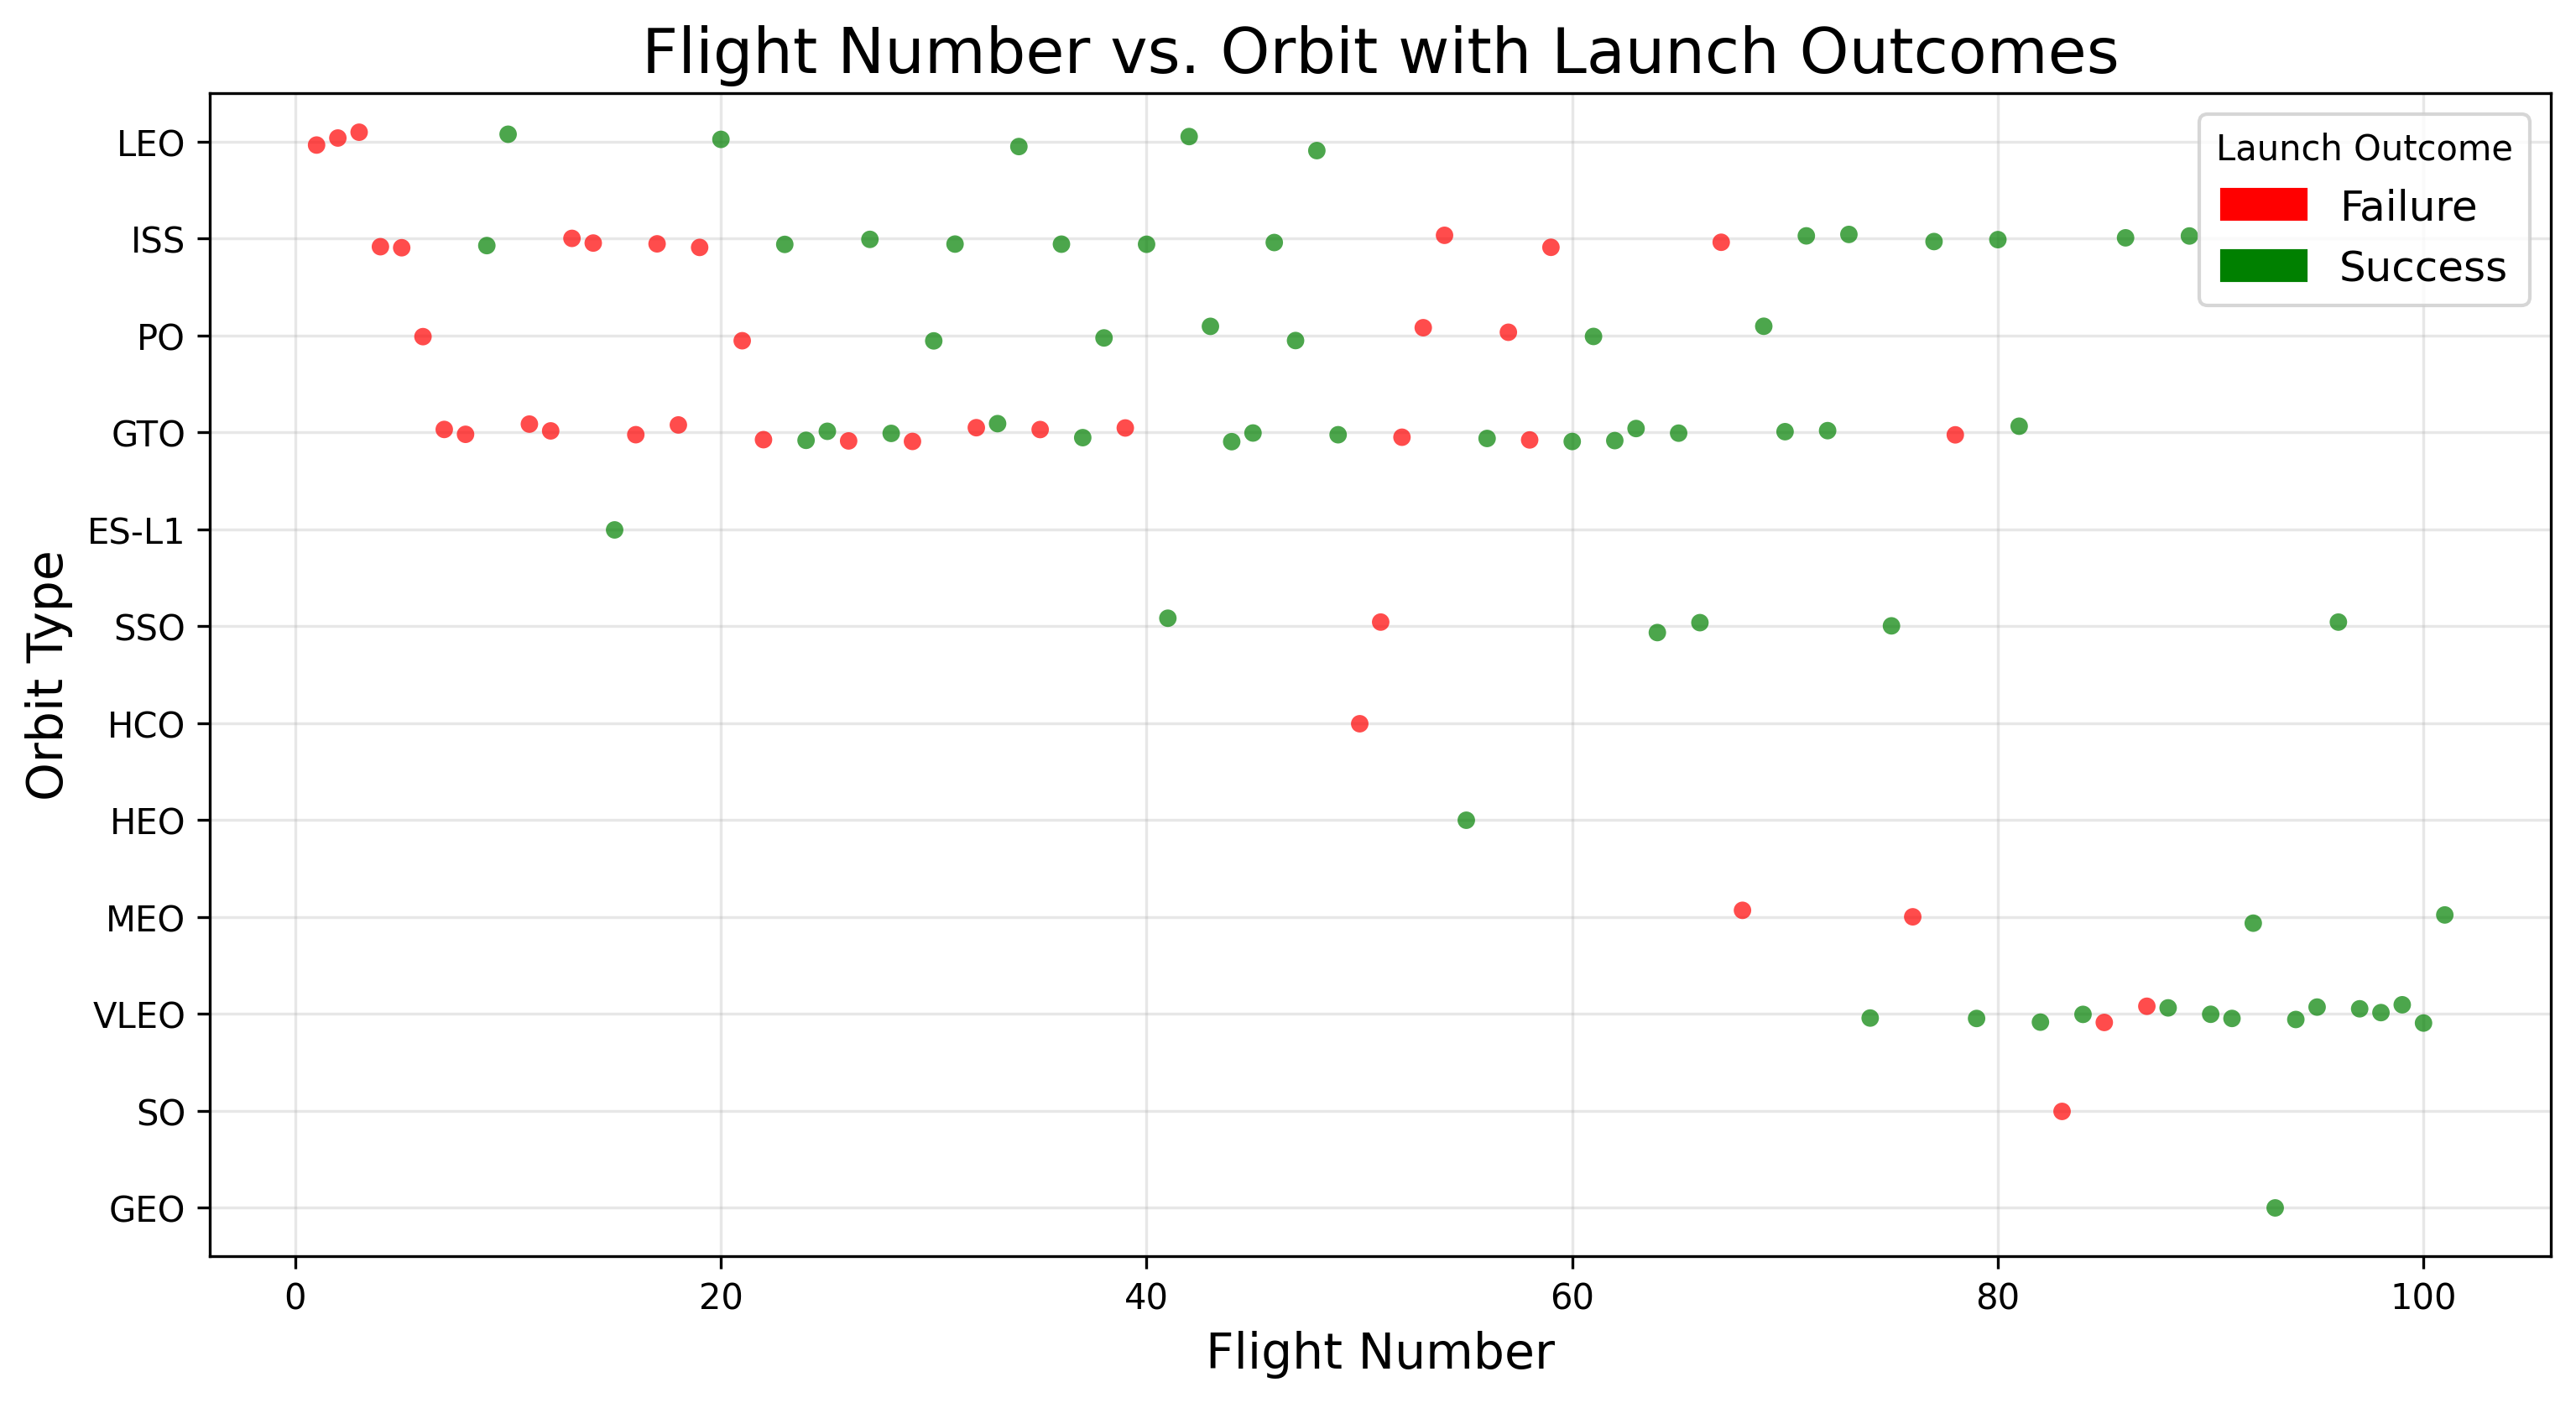

In [ ]:
# Stripplot for Flight Number vs. Orbit with Class hue
plt.figure(figsize=(12, 6), dpi=300)
sns.stripplot(
    x="FlightNumber",
    y="Orbit",
    hue="Class",
    data=data_falcon9,
    jitter=True,
    palette={0: 'red', 1: 'green'},
    alpha=0.7
)
plt.title("Flight Number vs. Orbit with Launch Outcomes", fontsize=18)
plt.xlabel("Flight Number", fontsize=14)
plt.ylabel("Orbit Type", fontsize=14)

legend_handles = [
    mpatches.Patch(color='red', label='Failure'),    # Red for Failure
    mpatches.Patch(color='green', label='Success')  # Green for Success
]

plt.legend(title="Launch Outcome", handles= legend_handles, loc="best", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

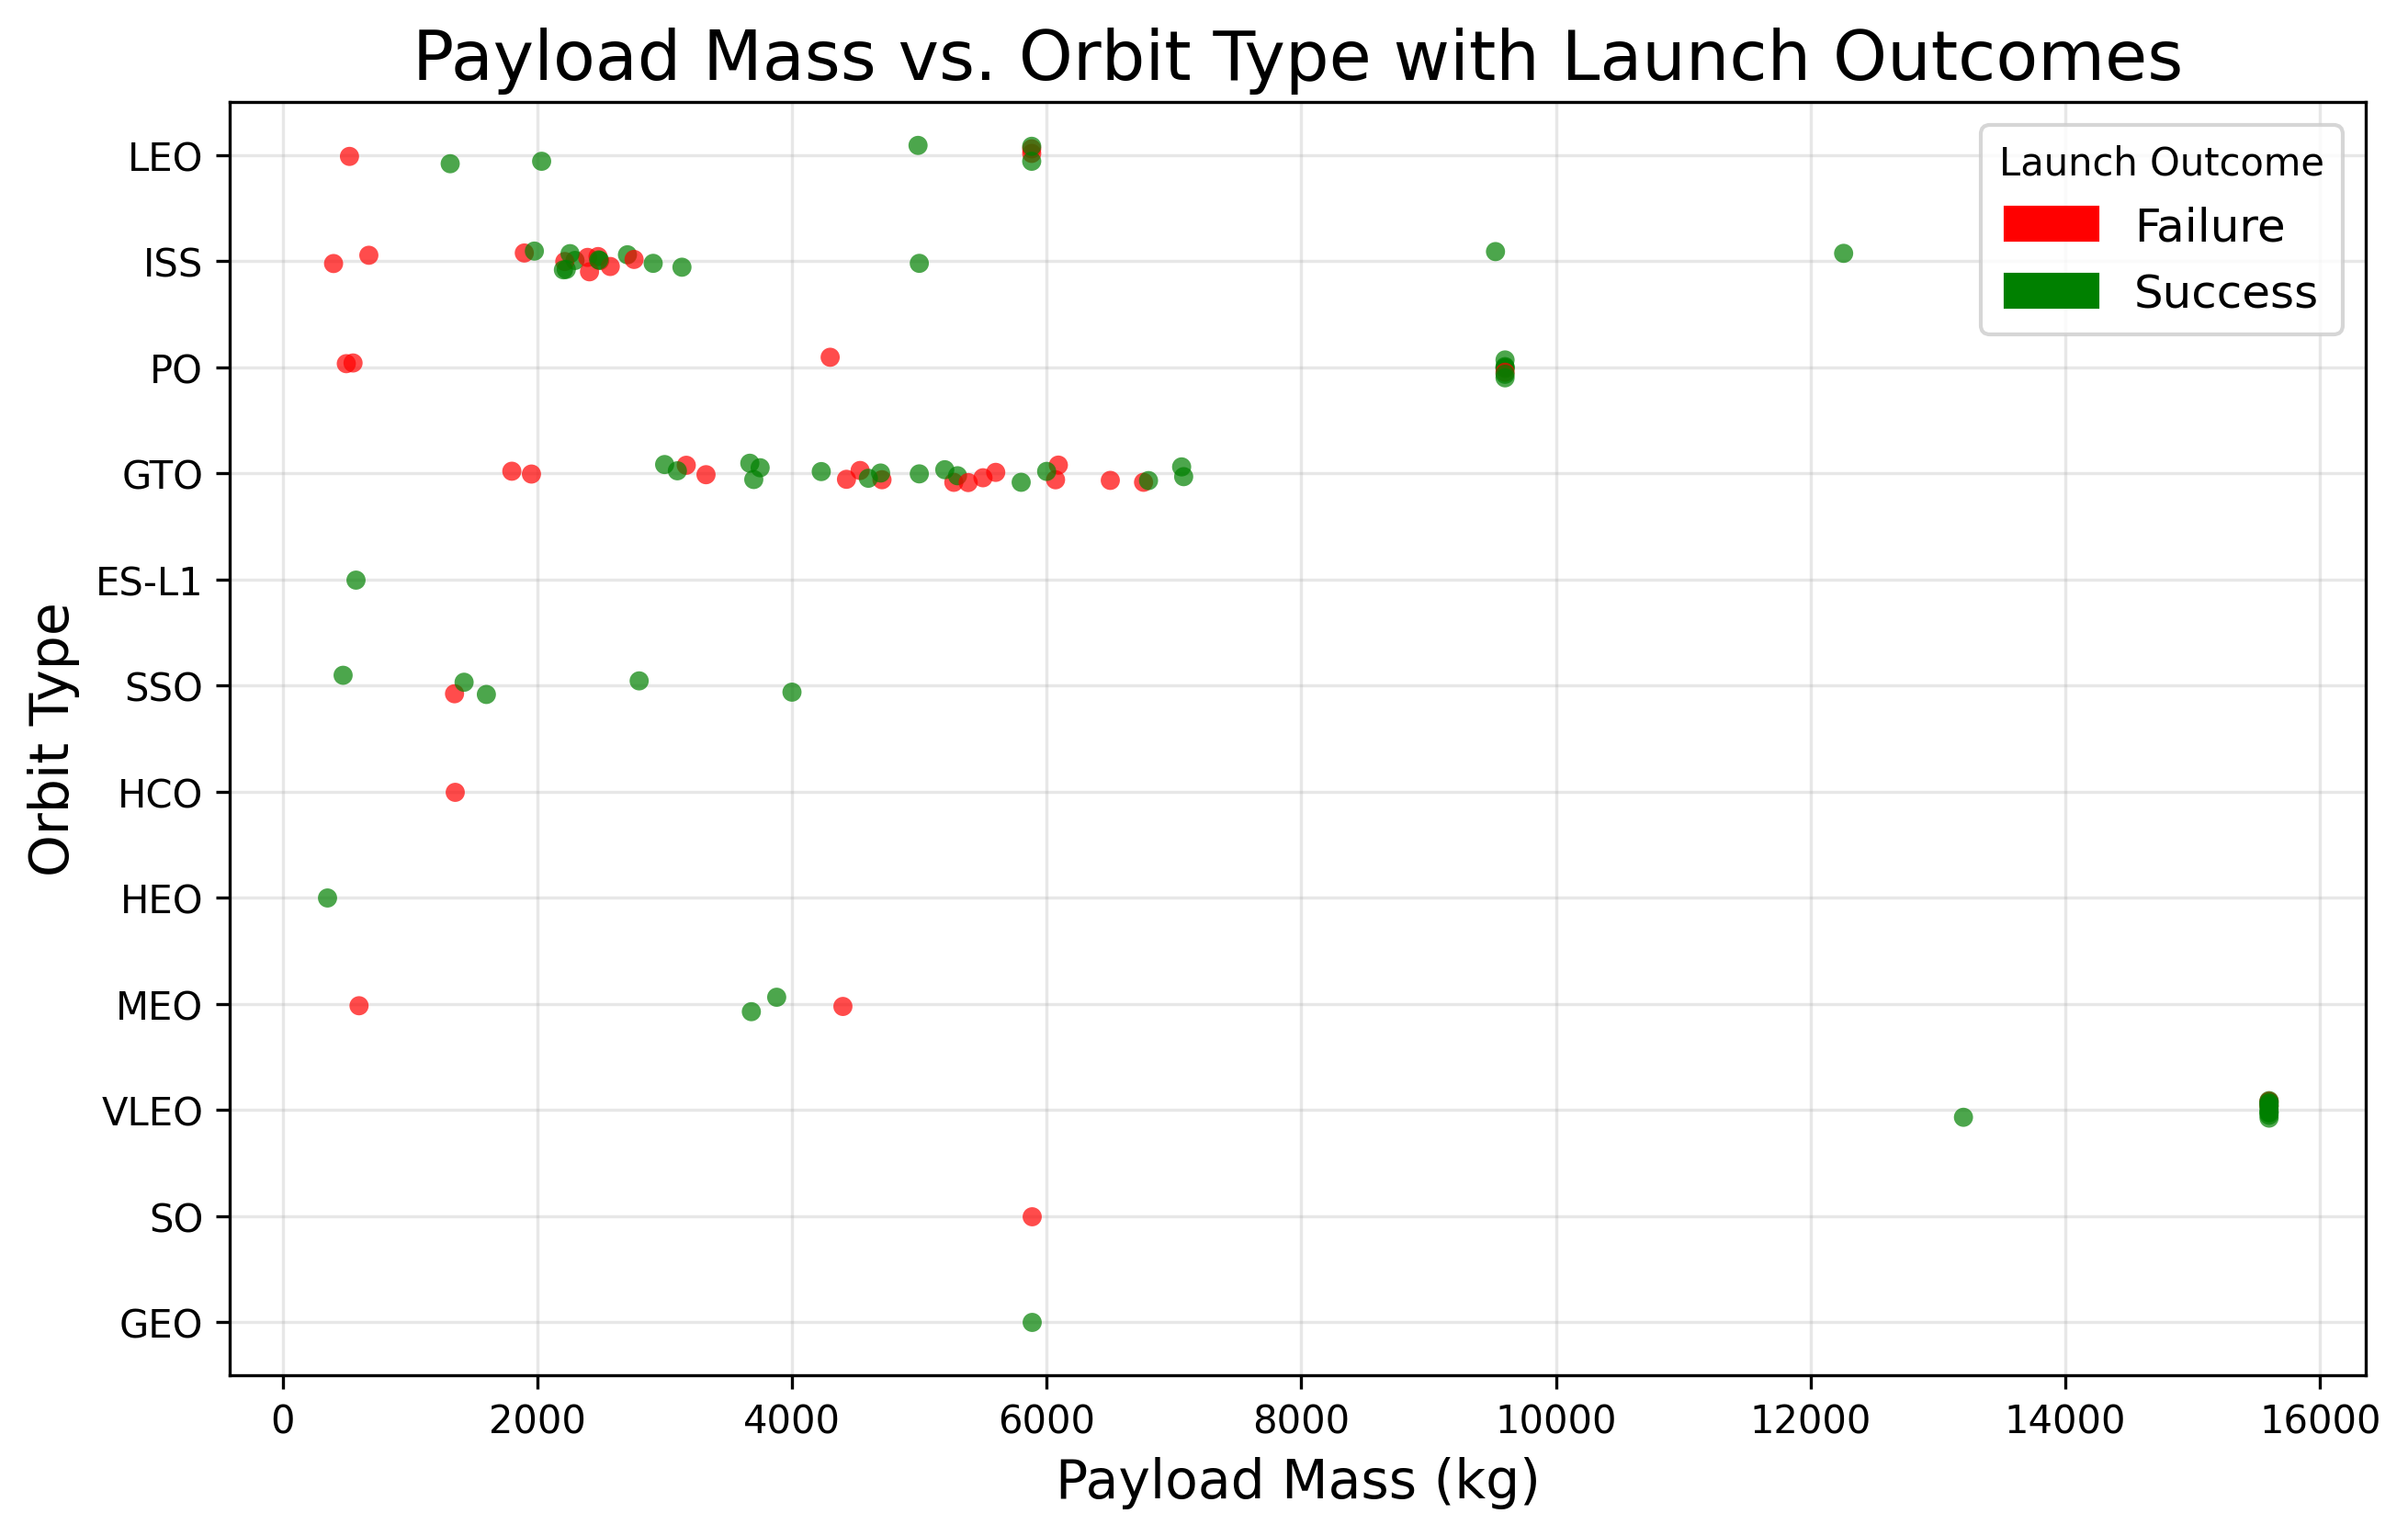

In [ ]:
# Stripplot for Payload Mass vs. Orbit with Launch Outcome
plt.figure(figsize=(10, 6), dpi=300)
sns.stripplot(
    x="PayloadMass",
    y="Orbit",
    hue="Class",
    data=data_falcon9,
    jitter=True,
    palette={0: 'red', 1: 'green'},
    alpha=0.7
)

plt.title("Payload Mass vs. Orbit Type with Launch Outcomes", fontsize=18)
plt.xlabel("Payload Mass (kg)", fontsize=14)
plt.ylabel("Orbit Type", fontsize=14)
legend_handles = [
    mpatches.Patch(color='red', label='Failure'),    # Red for Failure
    mpatches.Patch(color='green', label='Success')  # Green for Success
]
plt.legend(title="Launch Outcome", handles=legend_handles, loc="best", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

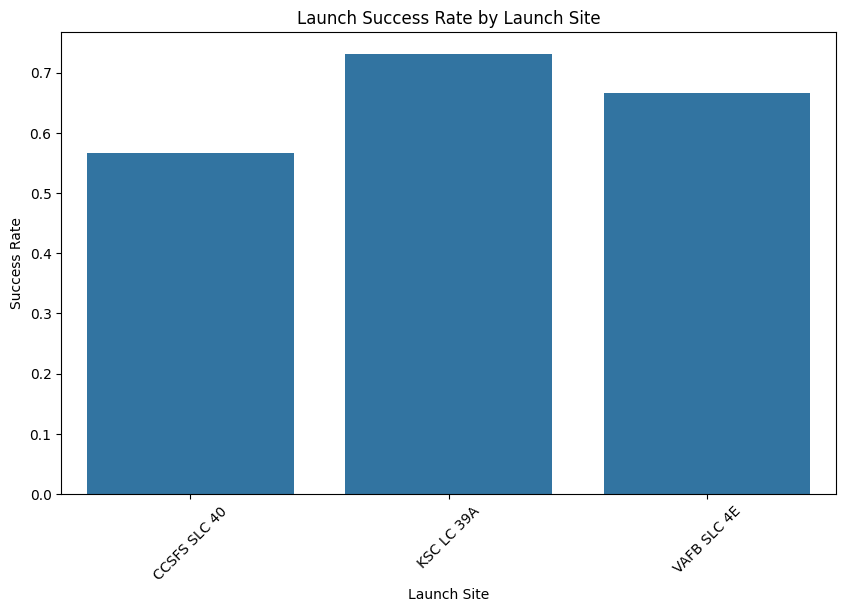

In [ ]:
# Calculate success rate by launch site
success_rate = data_falcon9.groupby('LaunchSite')['Class'].mean().reset_index()

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='LaunchSite',
            y='Class',
            data=success_rate)
plt.title('Launch Success Rate by Launch Site')
plt.xlabel('Launch Site')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()

<ipython-input-42-ec6db386476a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Year'] = pd.to_datetime(data_falcon9['Date']).dt.year


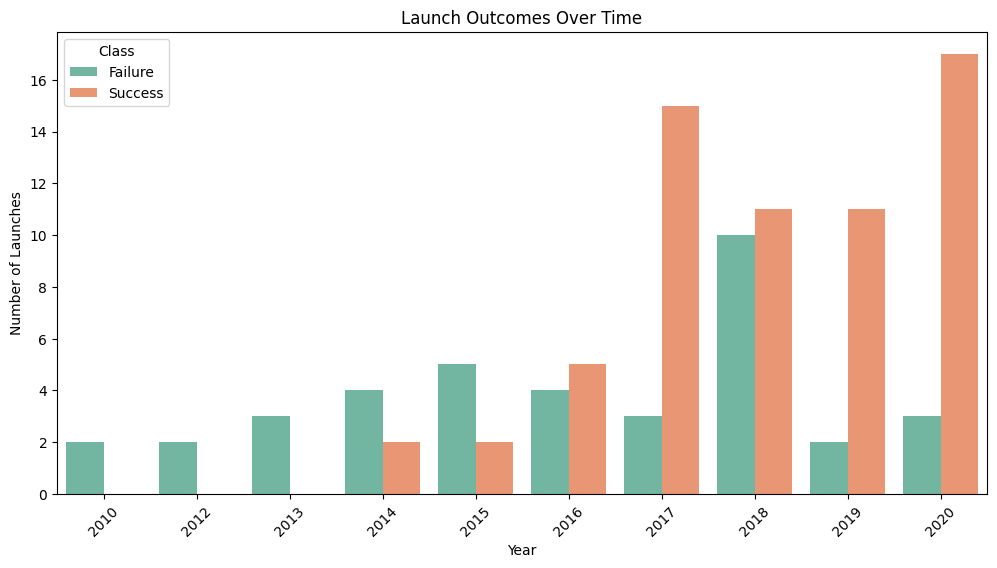

In [ ]:
# Calculate yearly success rates
data_falcon9['Year'] = pd.to_datetime(data_falcon9['Date']).dt.year

# Plot the number of successful and failed launches over time
plt.figure(figsize=(12, 6))
sns.countplot(x='Year',
              hue='Class',
              data=data_falcon9,
              palette='Set2')
plt.title('Launch Outcomes Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.legend(title='Class', labels=['Failure', 'Success'])
plt.xticks(rotation=45)
plt.show()

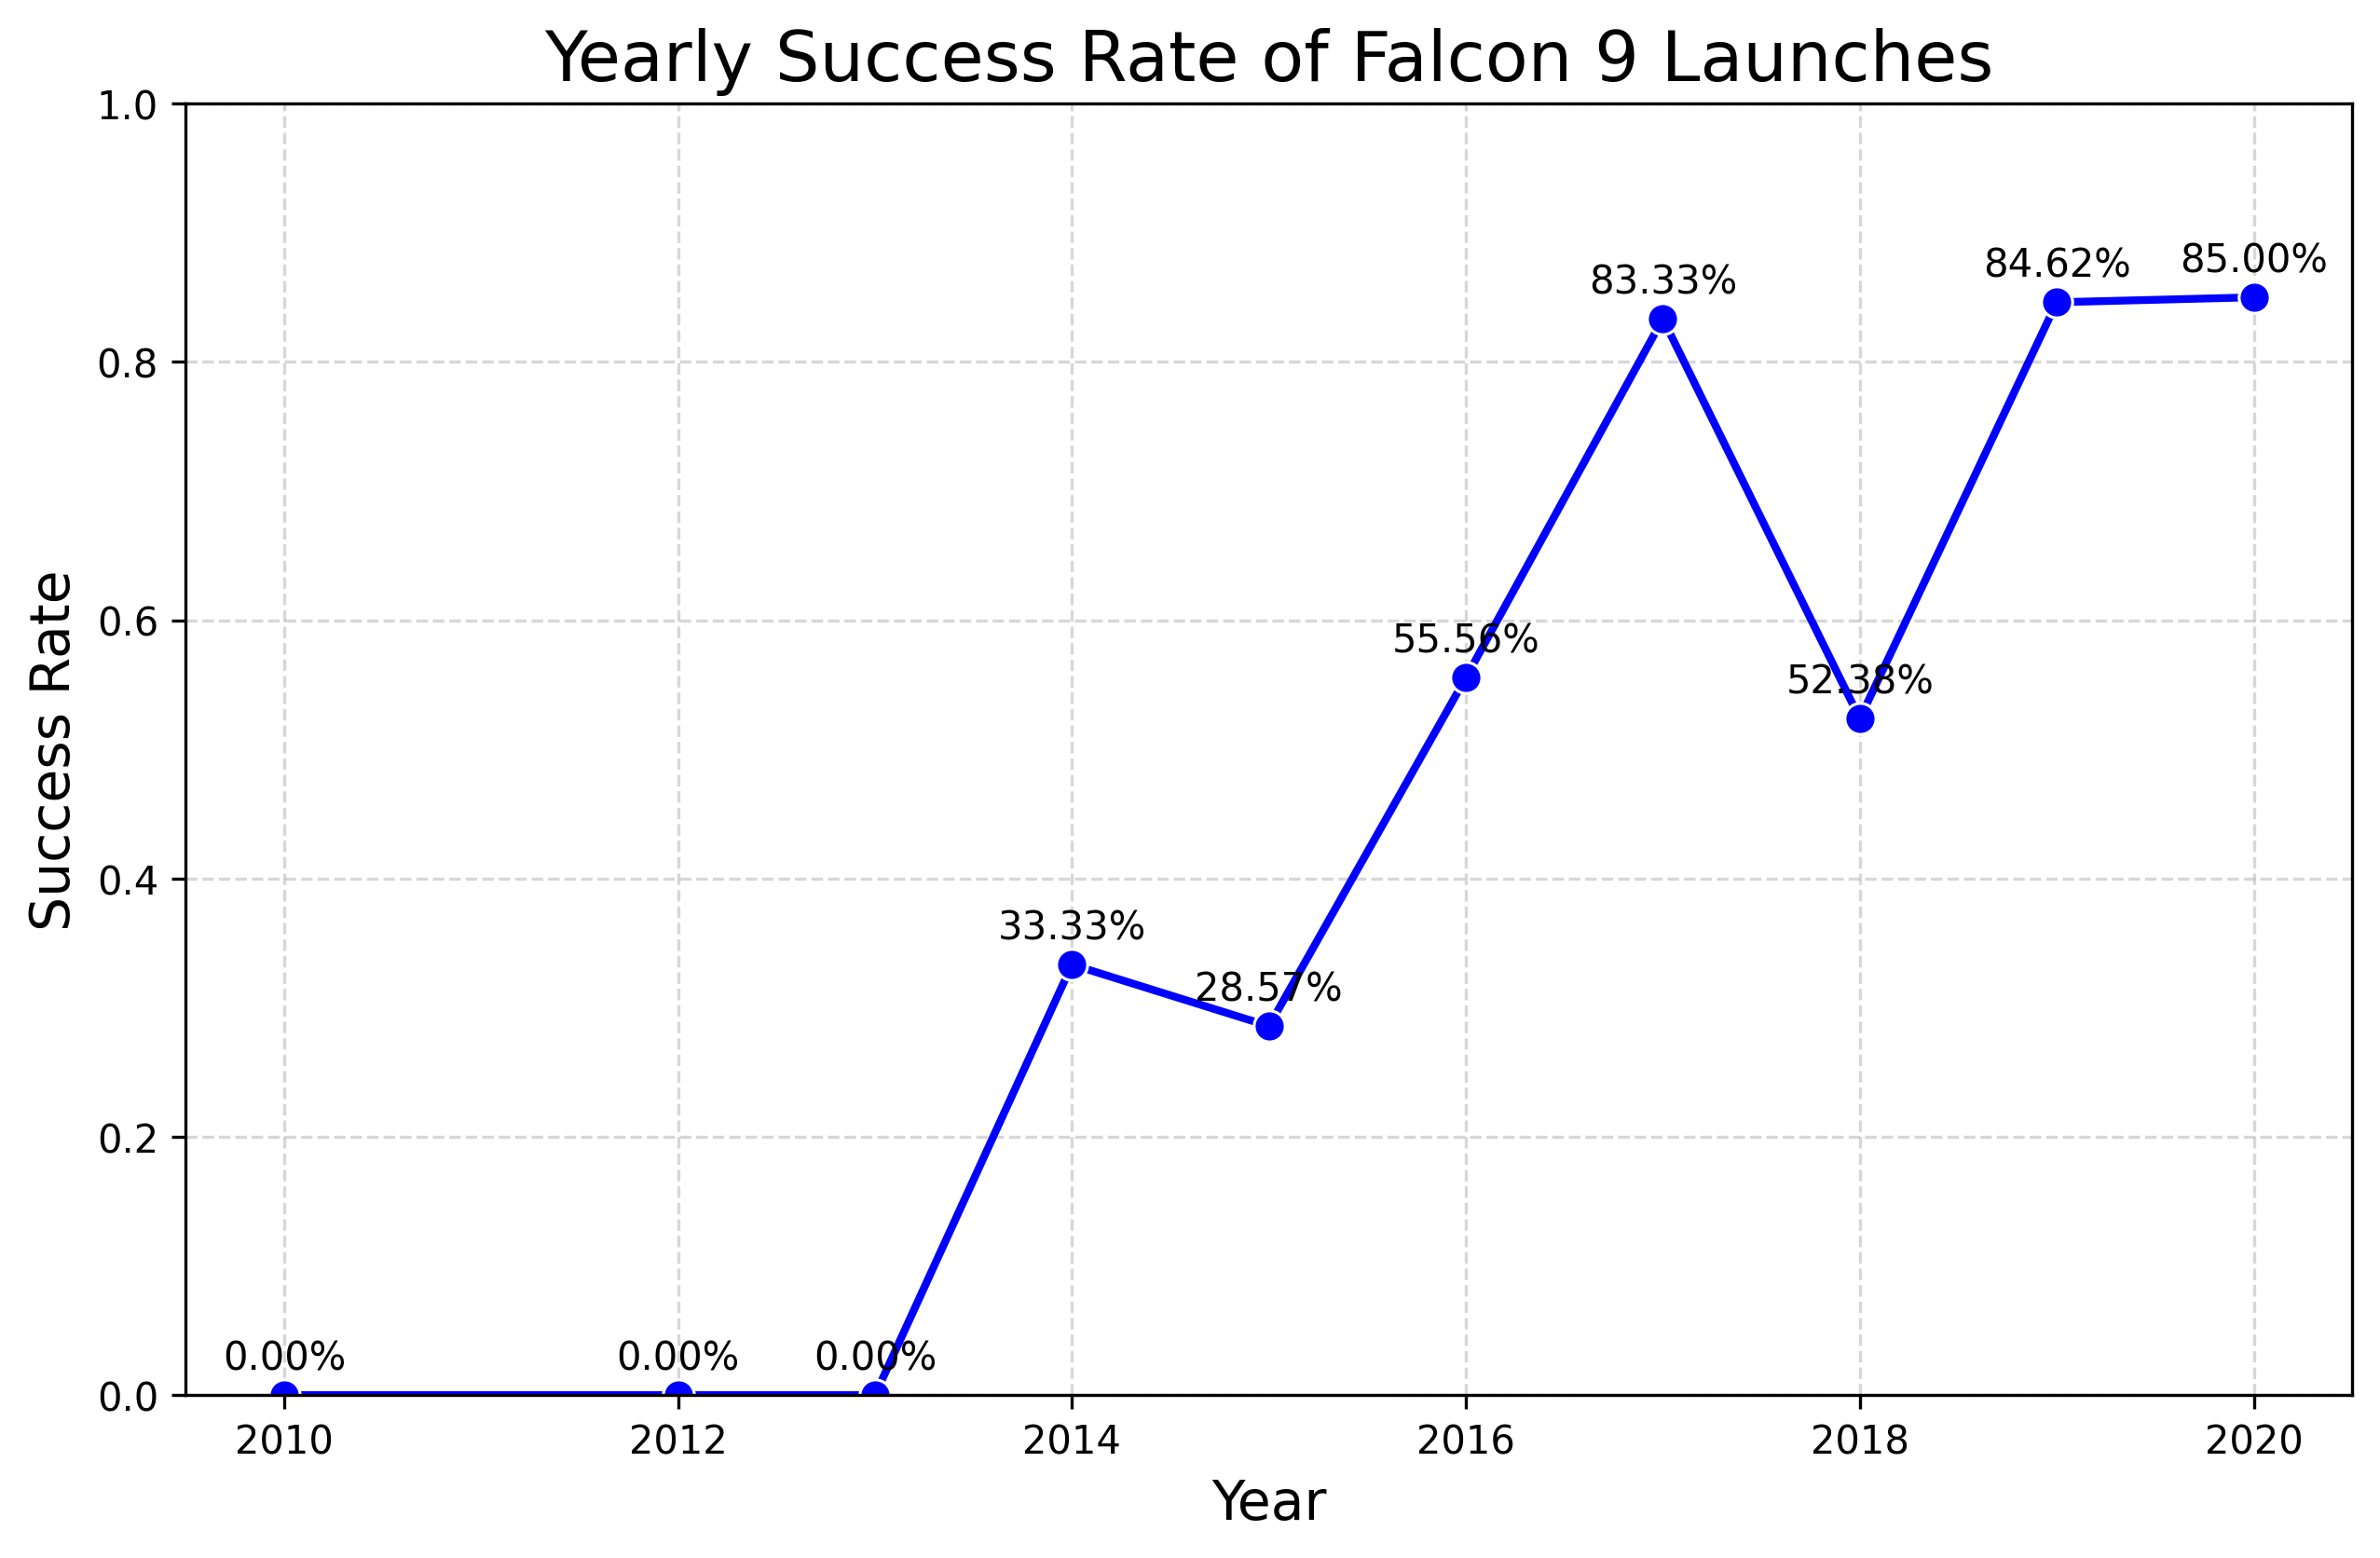

In [ ]:
# Calculate yearly success rates
temp_df = data_falcon9.groupby('Year', as_index=False)['Class'].mean()

# Plot the yearly success rate
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(x="Year",
             y="Class",
             data=temp_df,
             marker='o',
             linewidth=2,
             markersize=8,
             color="blue")

plt.title("Yearly Success Rate of Falcon 9 Launches", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Success Rate", fontsize=14)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)

# Highlighting key data points
for year, rate in zip(temp_df["Year"], temp_df["Class"]):
    plt.text(year, rate + 0.02, f"{rate:.2%}", horizontalalignment='center', fontsize=10)

# Show the plot
plt.show()

Conclusions:

## Interactive visualization

In [ ]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px

In [ ]:
# Initialize the Dash app
app = dash.Dash(__name__)

# Prepare dynamic dropdown options and slider range
min_payload = data_falcon9['PayloadMass'].min()
max_payload = data_falcon9['PayloadMass'].max()
dropdown_options = [{'label': 'All Sites', 'value': 'ALL'}] + \
                   [{'label': site, 'value': site} for site in data_falcon9['LaunchSite'].unique()]

# Define app layout
app.layout = html.Div([
    html.H1('SpaceX Launch Records Dashboard',
            style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40}),

    # Dropdown for site selection
    dcc.Dropdown(id='site-dropdown',
                 options=dropdown_options,
                 value='ALL',
                 placeholder='Select Launch Site',
                 searchable=False,
                 style={'width': '50%', 'padding': '3px', 'font-size': 20}),

    html.Br(),
    # html.Div(id='dd-output-container'),
    # html.Br(),
    # Pie chart for success counts
    html.Div(dcc.Graph(id='success-pie-chart')),

    html.Br(),

    html.P("Payload range (Kg):"),

    # Payload range slider
    dcc.RangeSlider(id='payload-slider',
                    min=min_payload,
                    max=max_payload,
                    step=1000,
                    marks={int(i): f'{int(i)}' for i in range(int(min_payload), int(max_payload) + 1, 5000)},
                    value=[min_payload, max_payload]),

    # Scatter plot for payload vs success
    html.Div(dcc.Graph(id='success-payload-scatter-chart')),
])

# Callback for pie chart
@app.callback(Output('success-pie-chart', 'figure'),
              Input('site-dropdown', 'value'))
def get_pie_chart(entered_site):
    filtered_df = data_falcon9
    if entered_site == 'ALL':
        fig = px.pie(filtered_df,
                     values='Class',
                     names='LaunchSite',
                     title='Total Success Launches By Site')
    else:
        data = filtered_df.groupby(['LaunchSite', 'Class'])['Class'].count().reset_index(name='Count')
        filtered_df = data[data.LaunchSite == entered_site]
        fig = px.pie(filtered_df,
                     values='Count',
                     names='Class',
                     title=f'Total Success Launches for Site {entered_site}')
    return fig

# # Test Callback
# @app.callback(
#     Output(component_id='dd-output-container', component_property='children'),
#     Input(component_id='site-dropdown', component_property='value'))

# def update_output(value):
#     return f'You have selected {value}'

# Callback for scatter plot
@app.callback(Output('success-payload-scatter-chart', 'figure'),
              [Input('site-dropdown', 'value'),
               Input('payload-slider', 'value')])
def get_scatter_chart(entered_site, payload):
    filtered_df = data_falcon9[(data_falcon9['PayloadMass'] >= payload[0]) &
                               (data_falcon9['PayloadMass'] <= payload[1])]
    if entered_site == 'ALL':
        fig = px.scatter(filtered_df,
                         x='PayloadMass',
                         y='Class',
                         color='BoosterVersion',
                         title='Correlation between Payload and Success for All Sites')
    else:
        filtered_df = filtered_df[filtered_df['LaunchSite'] == entered_site]
        fig = px.scatter(filtered_df,
                         x='PayloadMass',
                         y='Class',
                         color='BoosterVersion',
                         title=f'Correlation between Payload and Success for {entered_site}')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server()

<IPython.core.display.Javascript object>

## Geographical Distribution of Launch Sites

In [ ]:
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
from math import sin, cos, sqrt, atan2, radians

In [ ]:
# Extract relevant data from the main dataset and assign colors
# based on launch outcome: Green for success, Red for failure.

gps_data = data_falcon9[['LaunchSite', 'Latitude', 'Longitude', 'Class']].copy()
gps_data['Color'] = gps_data['Class'].map({1: 'green', 0: 'red'})

In [ ]:
# This function takes a DataFrame as input and generates a Folium map.
# Features:
#  - Markers for launch sites with custom icons and colors
#  - Clustered markers for better visualization
#  - Blue circles to represent the area around each site

def generate_map(df, start_lat, start_lon, end_lat, end_lon):

  """
  Generates a Folium map with markers, polylines, and a distance label.
  Args:
      df (pd.DataFrame): A DataFrame containing 'Latitude', 'Longitude', 'LaunchSite', and 'Class'.
      start_lat (float): Latitude of the start point (e.g., launch site).
      start_lon (float): Longitude of the start point (e.g., launch site).
      end_lat (float): Latitude of the end point (e.g., city or target).
      end_lon (float): Longitude of the end point (e.g., city or target).
  Returns:
      folium.Map: A Folium map with markers, a polyline, and the distance label.
  """

  if isinstance(df, pd.DataFrame):

    # Calculate the midpoint for the polyline
    midpoint_lat = (start_lat + end_lat) / 2
    midpoint_lon = (start_lon + end_lon) / 2

    # Calculate the distance between the two points
    def calculate_distance(lat1, lon1, lat2, lon2):
        R = 6373.0  # Radius of Earth in km
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

    distance = calculate_distance(start_lat, start_lon, end_lat, end_lon)

    # Define the initial map centered on the average coordinates
    data_falcon9_mean = [data_falcon9['Latitude'].mean(), data_falcon9['Longitude'].mean()]
    m = folium.Map(location= data_falcon9_mean, zoom_start=5)

    # Add marker clustering
    marker_cluster = MarkerCluster().add_to(m)

    for index, row in df.iterrows():

      # Add a marker for each launch site
      folium.Marker(
          location=[row['Latitude'],
                    row['Longitude']],
          popup=row['LaunchSite'],
          icon=DivIcon(
              icon_size=(80,20),
              icon_anchor=(0,0),
              html='<div style="font-size: 12; color:blue;"><b>{}</b></div>'.format(row['LaunchSite']))
          ).add_to(marker_cluster)

      # Add a rocket icon marker based on success/failure
      folium.Marker(
          location=[row['Latitude'], row['Longitude']],
          popup=row['LaunchSite'],
          icon=folium.Icon(color=row['Color'],
                           icon_color='white',
                           prefix='fa',
                           icon='rocket')
      ).add_to(marker_cluster)

      # Add a blue circle around the site
      folium.Circle(
          location=[row['Latitude'], row['Longitude']],
          radius=500,
          color='blue',
          fill=False,
          # fill_color='blue',
          fill_opacity=0.2,
          popup=row['LaunchSite']
          ).add_to(m)

      # Add mouse position tracker
      formatter = "function(num) {return L.Util.formatNum(num, 5);};"
      mouse_position = MousePosition(
      position='topright',
      separator=' Long: ',
      empty_string='NaN',
      lng_first=False,
      num_digits=5,
      prefix='Lat:',
      lat_formatter=formatter,
      lng_formatter=formatter
      ).add_to(m)

      # Add the polyline between start and end points
      folium.PolyLine(
          locations=[(start_lat, start_lon), (end_lat, end_lon)],
          color="blue",
          weight=2,
          opacity=0.8
      ).add_to(m)

      # Add a marker showing the distance at the city location
      folium.Marker(
          location=[midpoint_lat, midpoint_lon],
          icon=DivIcon(
          icon_size=(20, 20),
          icon_anchor=(0, 0),
        html=f'<div style="font-size: 12; color:blue;"><b>{distance:.2f} KM</b></div>')
          ).add_to(m)


    return m
  else:
    print("Input must be a Pandas DataFrame")

In [ ]:
launch_site_lat = 28.6081
launch_site_lon = -80.6034
airport_lat = 28.51401
airport_lon = -80.79899
m = generate_map(gps_data, launch_site_lat, launch_site_lon, airport_lat, airport_lon)
m

# Model Development

## Data Preparation

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
# Select relevant features
X = data_falcon9[['FlightNumber',
                  'PayloadMass',
                  'Orbit',
                  'LaunchSite',
                  'Flights',
                  'GridFins',
                  'Reused',
                  'Legs',
                  'LandingPad',
                  'Block',
                  'ReusedCount',
                  'Serial']]

# Handle missing values in 'LandingPad'
# X['LandingPad'] = X['LandingPad'].fillna('Missing')

# Check for missing values
print(X[['Orbit', 'LaunchSite', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Serial']].isnull().sum())


Orbit          0
LaunchSite     0
GridFins       0
Reused         0
Legs           0
LandingPad    31
Serial         0
dtype: int64


In [ ]:
# One-Hot Encoding for categorical features
categorical_cols = ['Orbit', 'LaunchSite', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Serial']
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
onehot_data = enc.fit_transform(X[categorical_cols].astype(str))

# Convert to DataFrame with column names
encoded_df = pd.DataFrame(
    onehot_data,
    columns=enc.get_feature_names_out(categorical_cols),
    index=X.index
).astype(float)

# Merge encoded features with numerical features
encoded_df = encoded_df.join(X[['FlightNumber', 'PayloadMass']])

# Define target variable
y = data_falcon9['Class']

# Standardize the features
scaler = StandardScaler()
scaled_X = scaler.fit_transform(encoded_df)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=2)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (80, 89), Test set shape: (21, 89)


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import numpy as np

In [ ]:
# Define hyperparameter grid
parameters = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

In [ ]:
# Initialize Logistic Regression model
lr = LogisticRegression()

# Perform Grid Search with 10-fold Cross-Validation
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [ ]:
# Get predictions on test data
yhat = logreg_cv.predict(X_test)

# Print best hyperparameters
print("🔹 Best hyperparameters: ", logreg_cv.best_params_)

# Print model accuracy scores
print(f"🔹 Model Training Accuracy: {logreg_cv.best_score_:.4f}")
print(f"🔹 Model Test Accuracy: {accuracy_score(Y_test, yhat):.4f}")

# Print classification report
print("\n🔹 Classification Report:\n", classification_report(Y_test, yhat))

🔹 Best hyperparameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
🔹 Model Training Accuracy: 0.8125
🔹 Model Test Accuracy: 0.8095

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.75      1.00      0.86        12

    accuracy                           0.81        21
   macro avg       0.88      0.78      0.79        21
weighted avg       0.86      0.81      0.80        21



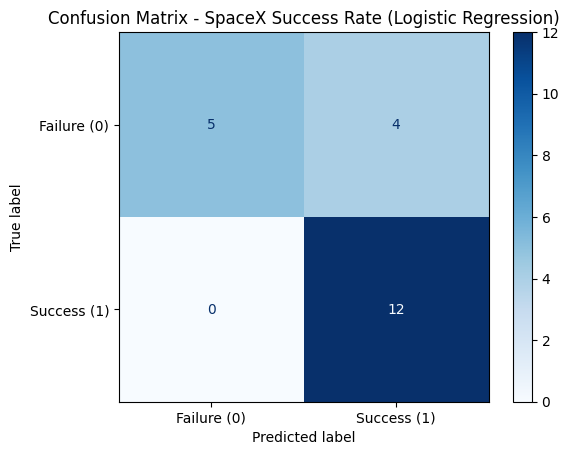

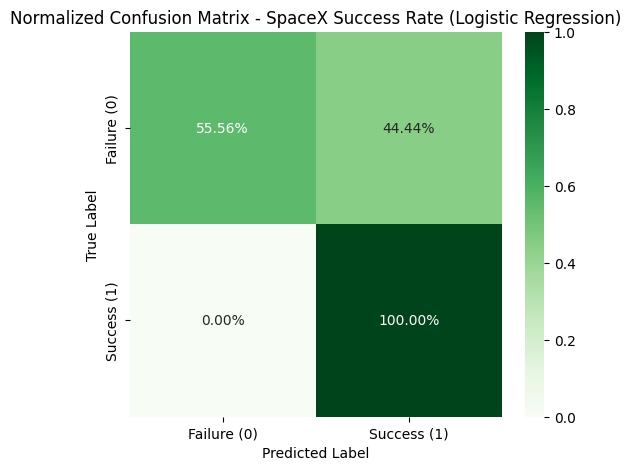

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, yhat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Failure (0)', 'Success (1)'])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - SpaceX Success Rate (Logistic Regression)')
plt.show()

# Normalize confusion matrix by row (i.e., by actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
plt.title('Normalized Confusion Matrix - SpaceX Success Rate (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Conclusion:**
* The model performs better on class 1 (Sucessful Landing) than class 0 (Failed Landing)
* Overall model accuracy is 81%
* The model only correctly identifies 55.6% of true negatives, missing several instances

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Define hyperparameter grid for SVM
parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-3, 3, 5),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 5))
}

In [ ]:
# Initialize SVM model
svm = SVC()

# Perform Grid Search with 10-fold Cross-Validation
svm_cv = GridSearchCV(svm, parameters, cv=10, n_jobs=-1, verbose=1)
svm_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': ['scale', 'auto', 0.001, 0.03162277660168379,
                                   1.0, 31.622776601683793, 1000.0],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=1)

In [ ]:
# Get predictions on test data
yhat = svm_cv.predict(X_test)

# Print best hyperparameters
print("🔹 Best hyperparameters: ", svm_cv.best_params_)

# Print model accuracy scores
print(f"🔹 Model Training Accuracy: {svm_cv.best_score_:.4f}")
print(f"🔹 Model Test Accuracy: {accuracy_score(Y_test, yhat):.4f}")

# Print classification report
print("\n🔹 Classification Report:\n", classification_report(Y_test, yhat))


🔹 Best hyperparameters:  {'C': 0.03162277660168379, 'gamma': 31.622776601683793, 'kernel': 'sigmoid'}
🔹 Model Training Accuracy: 0.8250
🔹 Model Test Accuracy: 0.8095

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.75      1.00      0.86        12

    accuracy                           0.81        21
   macro avg       0.88      0.78      0.79        21
weighted avg       0.86      0.81      0.80        21



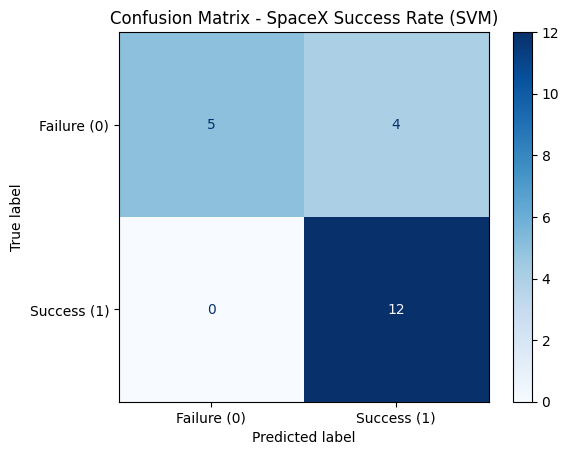

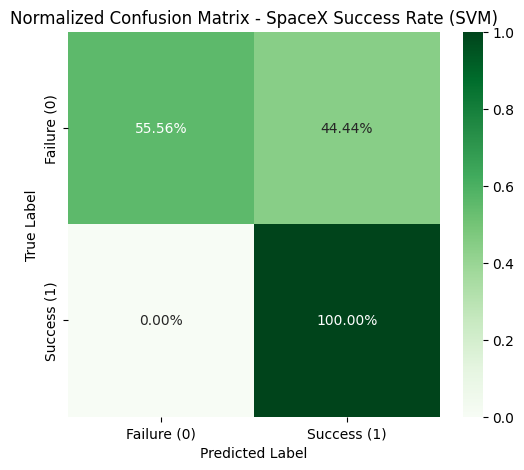

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, yhat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Failure (0)', 'Success (1)'])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - SpaceX Success Rate (SVM)')
plt.show()

# Normalize confusion matrix by row (i.e., by actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
plt.title('Normalized Confusion Matrix - SpaceX Success Rate (SVM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Conclusion:**
* The model performs better on class 1 (Sucessful Landing) than class 0 (Failed Landing)
* Overall model accuracy is 81%
* The model only correctly identifies 55.6% of true negatives, missing several instances

**Similar Results to Logistic Rregression (LR)**

## Decission Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
# Define hyperparameter grid
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
# Initialize Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with 10-fold Cross-Validation
tree_cv = GridSearchCV(tree, parameters, cv=10, n_jobs=-1, verbose=1)  # Use all available cores for efficiency
tree_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 972 candidates, totalling 9720 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             verbose=1)

In [ ]:
# Get predictions on test data
yhat = tree_cv.predict(X_test)

# Print best hyperparameters
print("🔹 Best hyperparameters: ", tree_cv.best_params_)

# Print model accuracy scores
print(f"🔹 Model Training Accuracy: {tree_cv.best_score_:.4f}")
print(f"🔹 Model Test Accuracy: {accuracy_score(Y_test, yhat):.4f}")

# Print classification report
print("\n🔹 Classification Report:\n", classification_report(Y_test, yhat))


🔹 Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
🔹 Model Training Accuracy: 0.8375
🔹 Model Test Accuracy: 0.7619

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.73      0.92      0.81        12

    accuracy                           0.76        21
   macro avg       0.78      0.74      0.74        21
weighted avg       0.78      0.76      0.75        21



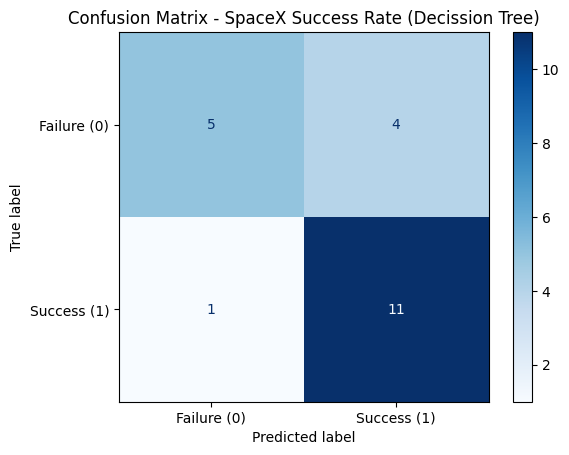

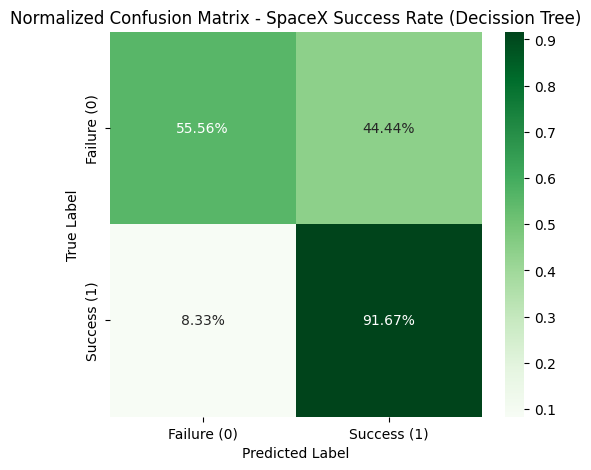

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, yhat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Failure (0)', 'Success (1)'])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - SpaceX Success Rate (Decission Tree)')
plt.show()

# Normalize confusion matrix by row (i.e., by actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
plt.title('Normalized Confusion Matrix - SpaceX Success Rate (Decission Tree)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

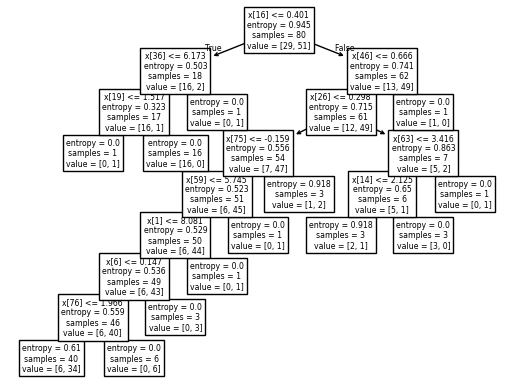

In [ ]:
plot_tree(tree_cv.best_estimator_)
plt.show()

**Conclusion:**
* Overall Decission Tree model accuracy is 76%
* The model performs better on class 1 (Sucessful Laning) than class 0 (Failed Landing)
* The model correctly identifies 55.6% of Failed Landings, and 91.2% of Successful Landings
* Worst performance model so far

## K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Define hyperparameter grid
parameters = {
    'n_neighbors': list(range(1, 11)),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

In [ ]:
# Initialize KNN classifier
knn = KNeighborsClassifier()

# Perform Grid Search with 10-fold Cross-Validation
knn_cv = GridSearchCV(knn, parameters, cv=10, n_jobs=-1, verbose=1)
knn_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             verbose=1)

In [ ]:
# Get predictions on test data
yhat = knn_cv.predict(X_test)

# Print best hyperparameters
print("🔹 Best hyperparameters: ", knn_cv.best_params_)

# Print model accuracy scores
print(f"🔹 Model Training Accuracy: {knn_cv.best_score_:.4f}")
print(f"🔹 Model Test Accuracy: {accuracy_score(Y_test, yhat):.4f}")

# Print classification report
print("\n🔹 Classification Report:\n", classification_report(Y_test, yhat))


🔹 Best hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
🔹 Model Training Accuracy: 0.8250
🔹 Model Test Accuracy: 0.8095

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.75      1.00      0.86        12

    accuracy                           0.81        21
   macro avg       0.88      0.78      0.79        21
weighted avg       0.86      0.81      0.80        21



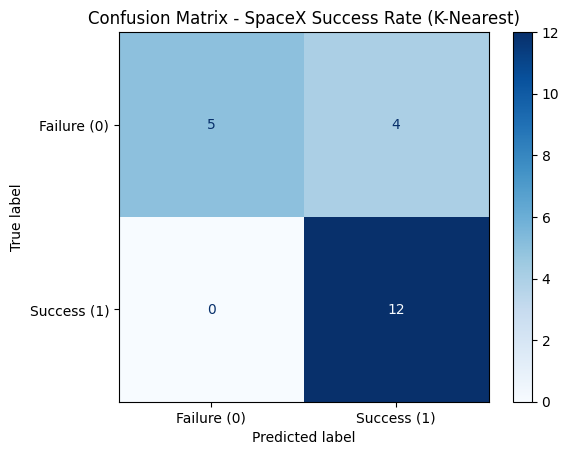

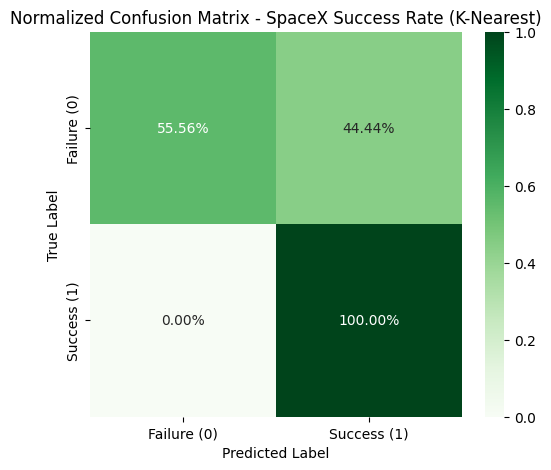

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, yhat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Failure (0)', 'Success (1)'])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - SpaceX Success Rate (K-Nearest)')
plt.show()

# Normalize confusion matrix by row (i.e., by actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
plt.title('Normalized Confusion Matrix - SpaceX Success Rate (K-Nearest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Conclusion:**
* Overall K Nearest model accuracy is 81%
* The model performs better on class 1 (Sucessful Laning) than class 0 (Failed Landing)
* The model correctly identifies 55.6% of Failed Landings, and 100% of Successful Landings

***The best overall model is Logistic Regression***